<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DSI 37 Capstone

<a id='part_iii'></a>
[Part I](Part_1-Cleaning.ipynb#part_i)<br>
[Part II](Part-2_Cleaning_and_EDA#part_ii)<br>
[Part IV](Part_4-Modelling.ipynb#part_iv) <br>
[Part V](Part_5-Implementation.ipynb#part_v)

# Part III: EDA Part 2

<a id='part_iii'></a>

## Contents

[1. Imports (Libraries)](#imports)<br>
[2. Imports (Data)](#data_imports)<br>
[3. EDA](#eda)<br>
[4. Summary of Findings](#eda_summary)<br>
[5. Unsupervised Learning](#unsup)<br>
[6. Identification of Three Classes](#classes)<br>
[7. Manual Creation of Three Classes](#classes2)<br>
[8. Testing](#test_model)<br>
[7. CSV Export](#export)





## 1. Imports (Libraries)

<a id='imports'></a>

In [1]:
# basic dependencies
import os
import datetime as dt
import pandas as pd
import numpy as np
import csv

In [2]:
# basic visualisation
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import seaborn as sns

In [3]:
# video capture
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
# Import imblearn libraries
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

In [5]:
# Import sklearn libraries

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelBinarizer

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from sklearn.datasets import make_blobs
import sklearn.metrics as sm
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score


In [6]:
import matplotlib.style as style
style.use('seaborn-v0_8')

In [7]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## 2. Imports (Data)

<a id='imports_data'></a>

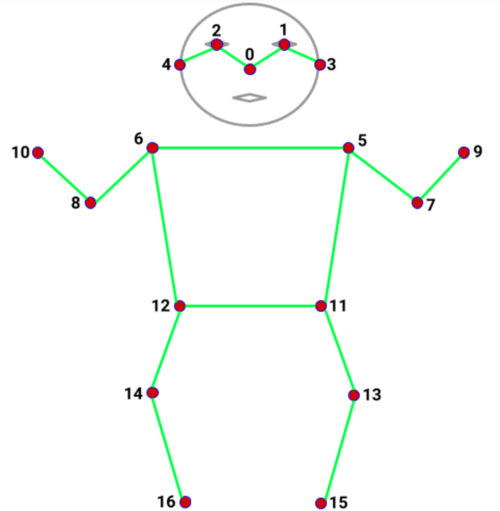

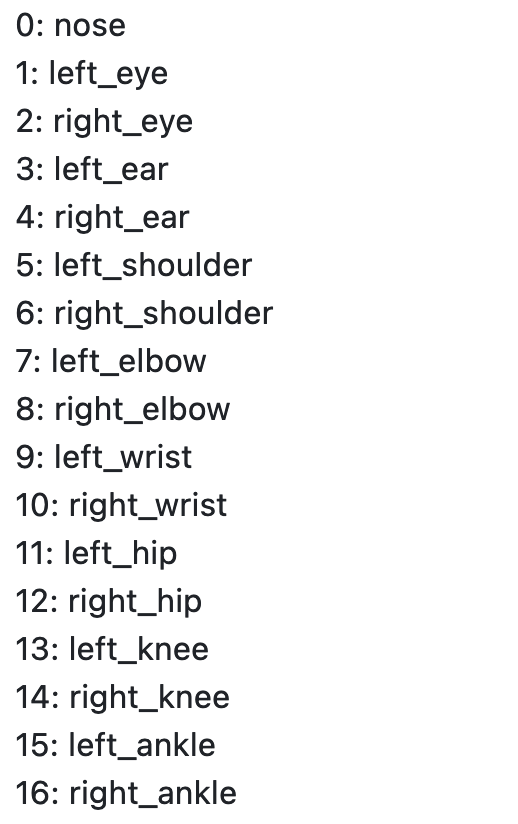

The csv file was created in the previous file [Part II](Part_2-Cleaning_and_EDA#part_ii)

There are a total of 60 columns. 

The first column is the class, of which there are only two options: jab or kick. 

The following 51 consist of 3 values for each of the 17 keypoints listed above. The three values, in order, are the normalised y co-ordinate, the normalised x co-ordinate, and the confidence of the keypoint. To be further explained in the data dictionary. To avoid repetition, I will only explain the x, y, and confidence values once. The naming convention for these 51 features are bodypart_x, bodypart_y, and bodypart_conf. For example for the nose: nose_x, nose_y, nose_conf. 

The last 8 columns are features that I created. See the data dictionary for more information.

#### Data dictionary:

|column| datatype|explanation|
|:-|:-:|:-|
|**class**|*string*| The name of the class. Pre-labelled based on the videos. Either `jab` or `kick`.|
|**bodypart_y**|*float*| The scaled y co-ordinate of the bodypart. The value is from 0 to 1.|
|**bodypart_x**|*float*| The scaled x co-ordinate of the bodypart. The value is from 0 to 1.|
|**bodypart_conf**|*float*| The confidence level of the keypoint. Meaning how confident MoveNet was that this is the actual location of the bodypart in question. The value is from 0 to 1.|
|**left_elbow_angle**|*float*| The angle of the left elbow, in degrees. Measured in relation to the left shoulder and wrist.|
|**left_hip_angle**|*float*| The angle of the left hip, in degrees. Measured in relation to the left shoulder and knee.|
|**left_knee_angle**|*float*| The angle of the left knee, in degrees. Measured in relation to the left hip and ankle.|
|**right_elbow_angle**|*float*| The angle of the right elbow, in degrees. Measured in relation to the right shoulder and wrist.|
|**right_hip_angle**|*float*| The angle of the right hip, in degrees. Measured in relation to the right shoulder and knee.|
|**right_knee_angle**|*float*| The angle of the right knee, in degrees. Measured in relation to the right hip and ankle.|
|**left_eye_left_wrist**|*float*| The scaled distance between the left eye and left wrist. The value is from 0 to 1.|
|**left_ankle_right_ankle**|*float*| The scaled distance between the left ankle and right ankle. The value is from 0 to 1.|

<br>


In [8]:
# Read coordinates csv file
df = pd.read_csv('../data/04-edited_csv/combined_coords.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30955 entries, 0 to 30954
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   class                   30955 non-null  object 
 1   nose_y                  30955 non-null  float64
 2   nose_x                  30955 non-null  float64
 3   nose_conf               30955 non-null  float64
 4   left_eye_y              30955 non-null  float64
 5   left_eye_x              30955 non-null  float64
 6   left_eye_conf           30955 non-null  float64
 7   right_eye_y             30955 non-null  float64
 8   right_eye_x             30955 non-null  float64
 9   right_eye_conf          30955 non-null  float64
 10  left_ear_y              30955 non-null  float64
 11  left_ear_x              30955 non-null  float64
 12  left_ear_conf           30955 non-null  float64
 13  right_ear_y             30955 non-null  float64
 14  right_ear_x             30955 non-null

## 3. EDA 

<a id='eda'></a>

As the previous codebook ended at the point where new features had been created, this codebook will begin with seeing the impact of the new features on the two classes.

### Contents - EDA
[A. Deducing Feature Importance](#ft_imp)<br>
[B. EDA of New Features](#eda_new)<br>
[C. Angles](#angles)<br>
[D. Distances](#distances)<br>


[Back to top](#part_iii)

### A - Deducing Feature Importance

<a id='ft_imp'></a>

Time to test the model one more time to see the impact the new features have.

In [10]:
X = df.drop('class', axis=1) # Store the Features
y = df['class'] # Store the Target value (i.e. Class Name)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

In [12]:
y_test

12284     jab
15667    kick
17243    kick
13793    kick
25541    kick
         ... 
29529    kick
10920     jab
12463     jab
8759      jab
3821      jab
Name: class, Length: 9287, dtype: object

In [13]:
# Logistic Regression
steps = [['smote', SMOTE(random_state = 42)],
         ('ss', StandardScaler()),
        ('lr', LogisticRegression(solver='liblinear'))]
lr_pipe = Pipeline(steps)

lr_params = {'lr__C': [0.1, 0.5, 1, 5, 10], 
            'lr__penalty': ['l1', 'l2']}

lr = GridSearchCV(lr_pipe, param_grid=lr_params, cv=5)


In [14]:
lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=42)],
                                       ('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'lr__C': [0.1, 0.5, 1, 5, 10],
                         'lr__penalty': ['l1', 'l2']})

In [15]:
lr.best_params_

{'lr__C': 5, 'lr__penalty': 'l1'}

In [16]:
# Making predictions
y_lr_pred = lr.predict(X_test)
y_lr_pred_proba = lr.predict_proba(X_test)

In [17]:
pred_prob_train = lr.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train[:,1])
pred_prob_test = lr.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test[:,1])

print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')


print(classification_report(y_test, y_lr_pred))

ROC-AUC on training set: 0.998877586757676
ROC-AUC on testing set: 0.9986800459302159
              precision    recall  f1-score   support

         jab       0.98      0.99      0.98      4142
        kick       0.99      0.99      0.99      5145

    accuracy                           0.99      9287
   macro avg       0.99      0.99      0.99      9287
weighted avg       0.99      0.99      0.99      9287



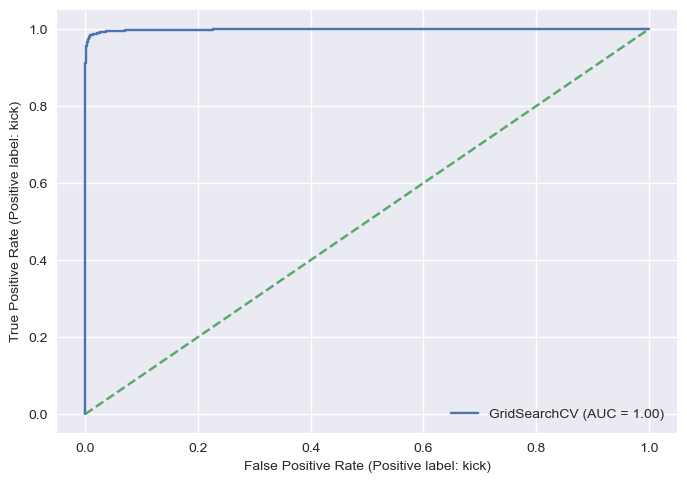

In [18]:
roc_display = RocCurveDisplay.from_estimator(lr,X_test,y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

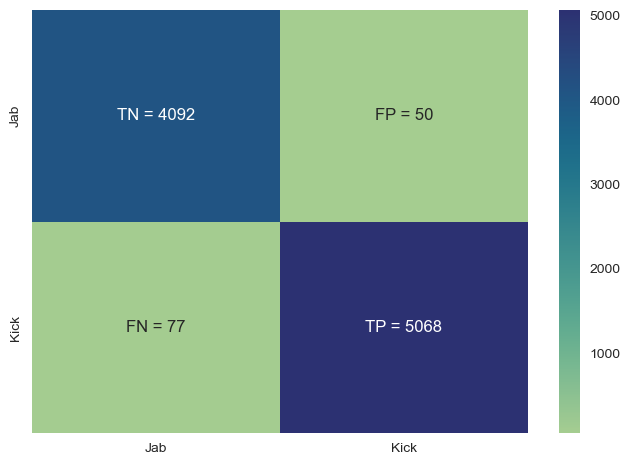

In [19]:
# plot confusion matrix heatmap
cm = confusion_matrix(y_test,lr.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['Jab','Kick'],
    yticklabels=['Jab','Kick']
)

In [20]:
coef = lr.best_estimator_['lr'].coef_[0]
feature = lr.best_estimator_['ss'].get_feature_names_out()

<Axes: xlabel='Importance', ylabel='Features'>

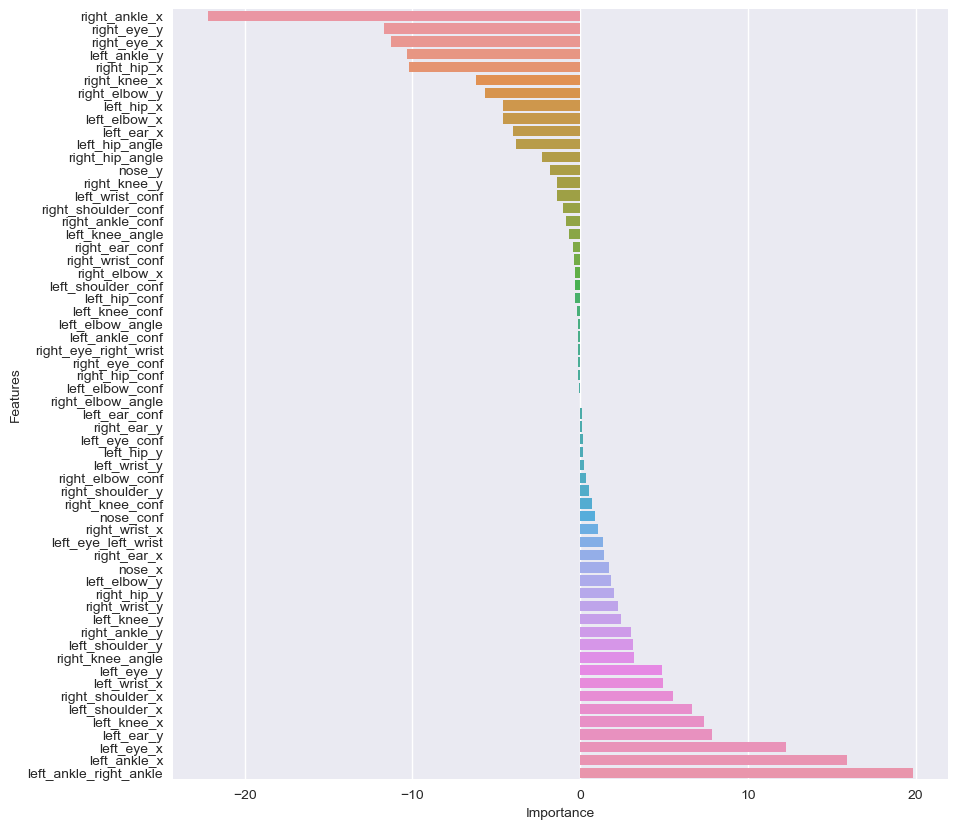

In [21]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(50, 'Importance')
bottom_features = feature_importance.nsmallest(50, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

Of my new features, the distance between the left ankle and right ankle stands out as the most important one. However, a number of my other engineered features also appear to have made it into the top 20 features, which gives me some hope of creating the `guard` class through unsupervised learning. I assume based on domain knowledge that there will be more instances of the `guard` class compared to the other two. Again: see the following images for reference:

#### Jab - Action Sequence

Guard - Jab - Guard

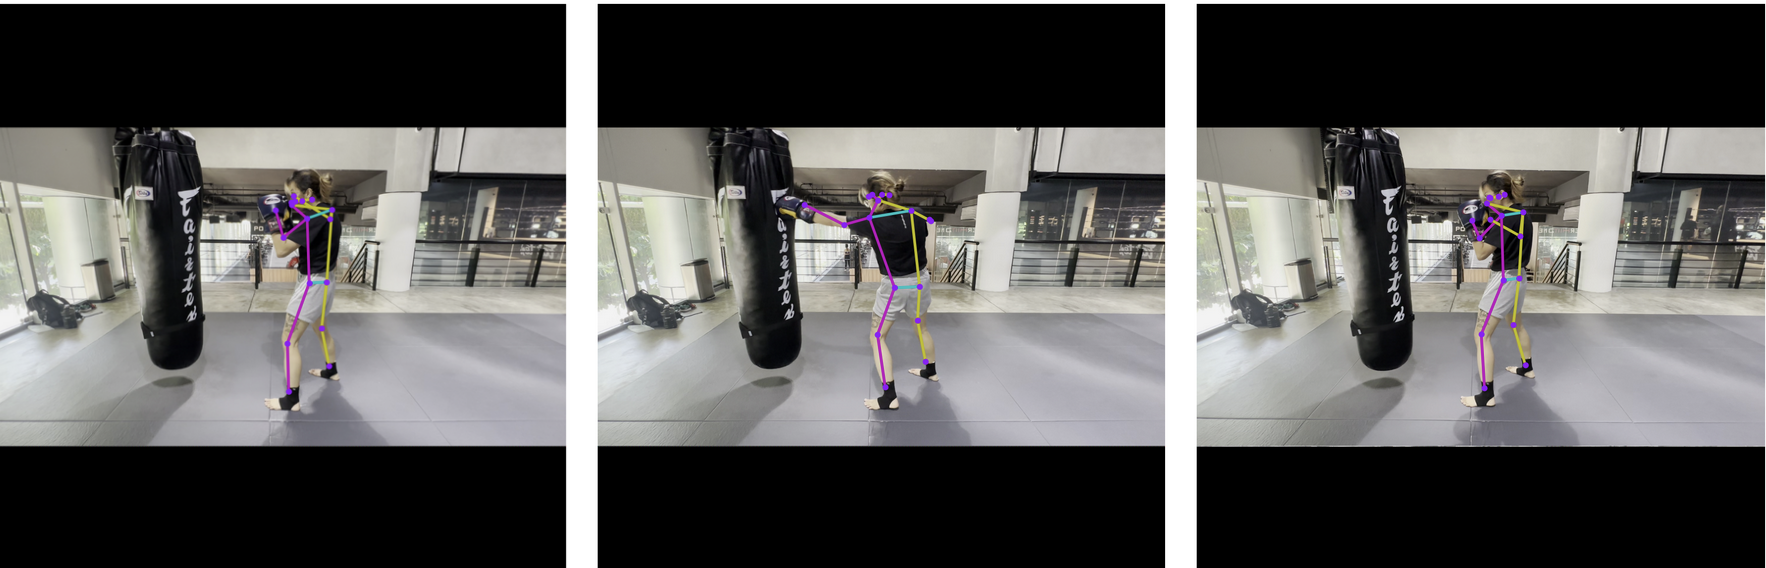

#### Kick - Action Sequence

Guard - Kick - Guard

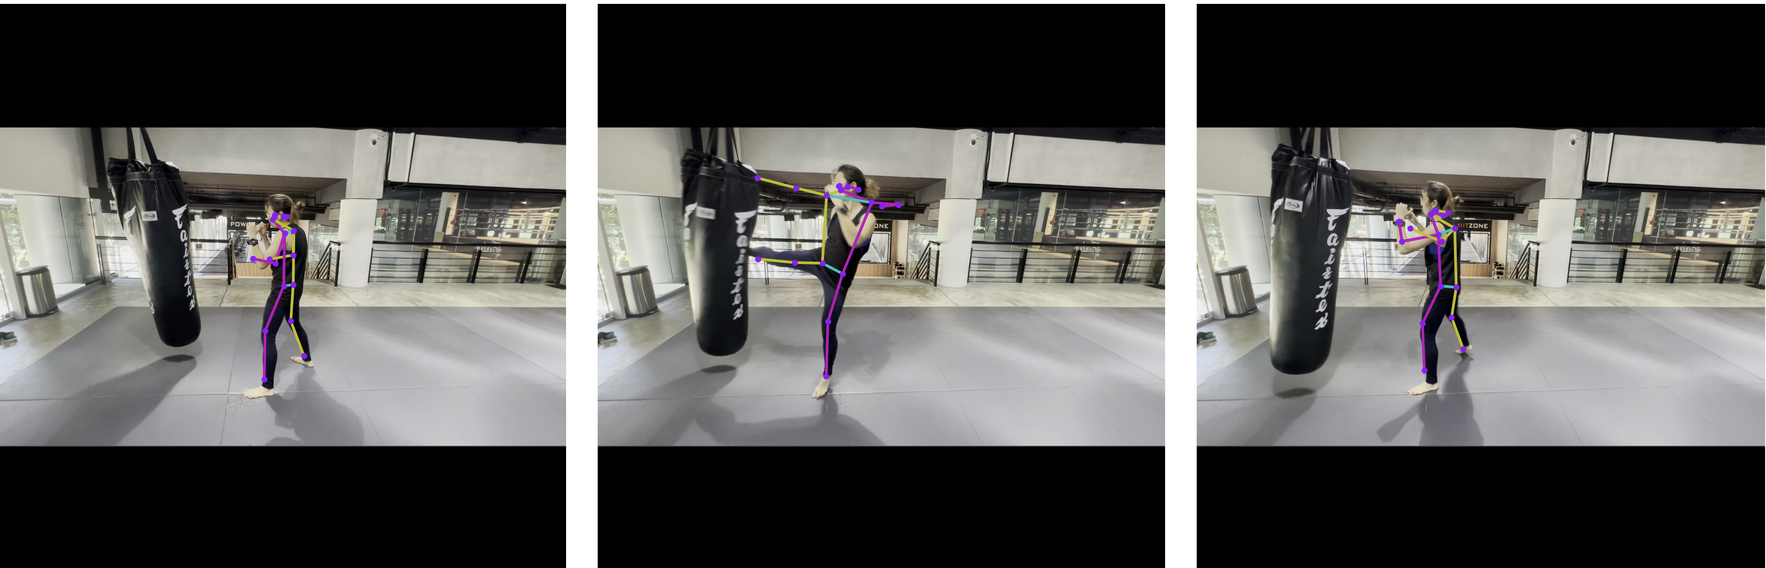

As can be seen from these two action sequences, there are 4x `guard` postures vs 1x `jab` and 1x `kick`.

Of course in reality since the kicks and jabs are continuous within each video and there are transitions between the `guard` and `jab` or `kick` postures above, it's not as simple as stating that there will be 4x as many `guard` instances as the other two classes. However, the number should still be higher. If it isn't, it means that the transition images are also being counted as `kick` or `jab` items. 

At this point I will now do three things:
1. Explore the new features, particularly to see their ranges for the two classes `jab` and `kick`.
2. Summarise my findings for the EDA in general, particularly for differentiation between the three classes.
3. Attempt some unsupervised learning methods to see if the third class `guard` can be identified in this manner
4. If step 3 is not successful then in the following codebook I will write functions based on step 2 to differentiate the classes manually so that a counter and recommender can be implemented

### B - EDA of New Features

<a id='eda_new'></a>

The 8 new features I created were (taken from data dictionary above):

|column| datatype|explanation|
|:-|:-:|:-|
|**left_elbow_angle**|*float*| The angle of the left elbow, in degrees. Measured in relation to the left shoulder and wrist.|
|**left_hip_angle**|*float*| The angle of the left hip, in degrees. Measured in relation to the left shoulder and knee.|
|**left_knee_angle**|*float*| The angle of the left knee, in degrees. Measured in relation to the left hip and ankle.|
|**right_elbow_angle**|*float*| The angle of the right elbow, in degrees. Measured in relation to the right shoulder and wrist.|
|**right_hip_angle**|*float*| The angle of the right hip, in degrees. Measured in relation to the right shoulder and knee.|
|**right_knee_angle**|*float*| The angle of the right knee, in degrees. Measured in relation to the right hip and ankle.|
|**left_eye_left_wrist**|*float*| The scaled distance between the left eye and left wrist. The value is from 0 to 1.|
|**left_ankle_right_ankle**|*float*| The scaled distance between the left ankle and right ankle. The value is from 0 to 1.|


First, I will split the dataframe back into `jab` and `kick` dataframes (j and k for brevity) to make visualisations easier.

In [22]:
j = df[df['class']=='jab']
j.shape

(13676, 61)

In [23]:
k = df[df['class']=='kick']
k.shape

(17279, 61)

Now I will proceed to study the 8 new features. As I did when I was creating them, I will consider them in two broad categories: joint angles and keypoint distances.

### C - Angles

<a id='angles'></a>

#### Left Elbow Angle

In [104]:
print('For the jab:')
print(f'The range of values for the left elbow angle is: {j["left_elbow_angle"].min():.2f} to {j["left_elbow_angle"].max():.2f} degrees.')



For the jab:
The range of values for the left elbow angle is: 11.99 to 179.49 degrees.


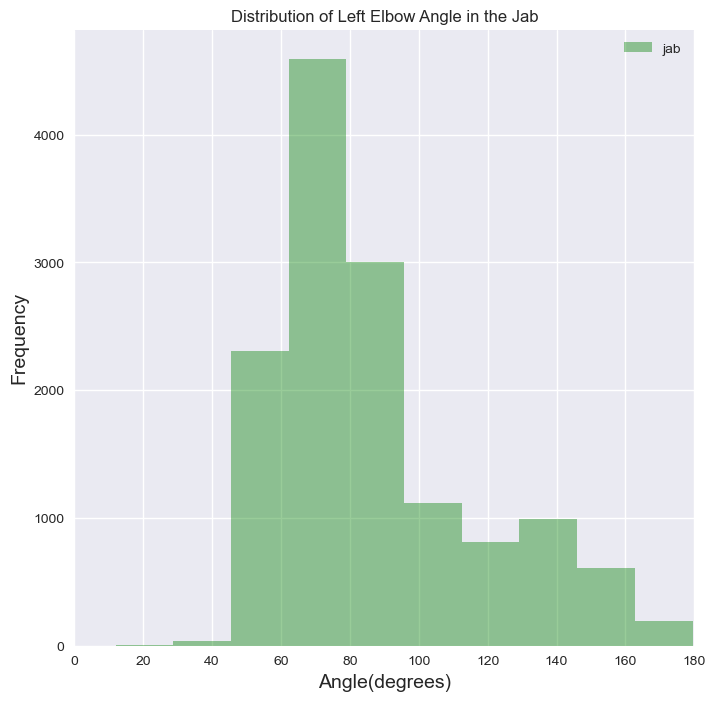

In [105]:
plt.figure(figsize = (8,8))

plt.hist(j['left_elbow_angle'], bins = 10, alpha = 0.4, color = 'g', label = j['class'])
plt.xlim(0,180)
plt.xlabel('Angle(degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Left Elbow Angle in the Jab')
plt.legend(loc='upper right')

In [106]:
print('For the kick:')
print(f'The range of values for the left elbow angle is: {k["left_elbow_angle"].min():.2f} to {k["left_elbow_angle"].max():.2f} degrees.')



For the kick:
The range of values for the left elbow angle is: 0.01 to 179.98 degrees.


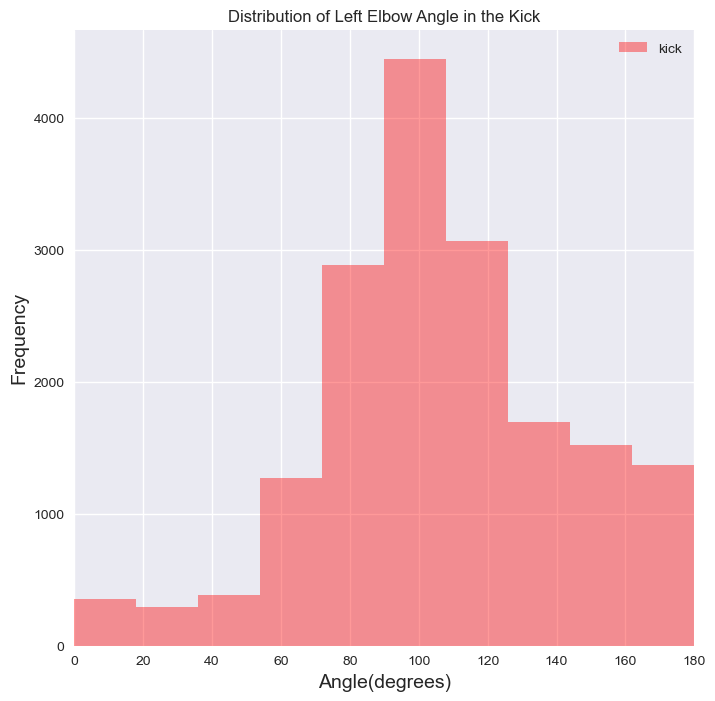

In [107]:
plt.figure(figsize = (8,8))

plt.hist(k['left_elbow_angle'], bins = 10, alpha = 0.4, color = 'r', label = k['class'])
plt.xlim(0,180)
plt.xlabel('Angle(degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Left Elbow Angle in the Kick')
plt.legend(loc='upper right')

Comment

#### Left Hip Angle

In [108]:
print('For the jab:')
print(f'The range of values for the left hip angle is: {j["left_hip_angle"].min():.2f} to {j["left_hip_angle"].max():.2f} degrees.')



For the jab:
The range of values for the left hip angle is: 130.60 to 171.45 degrees.


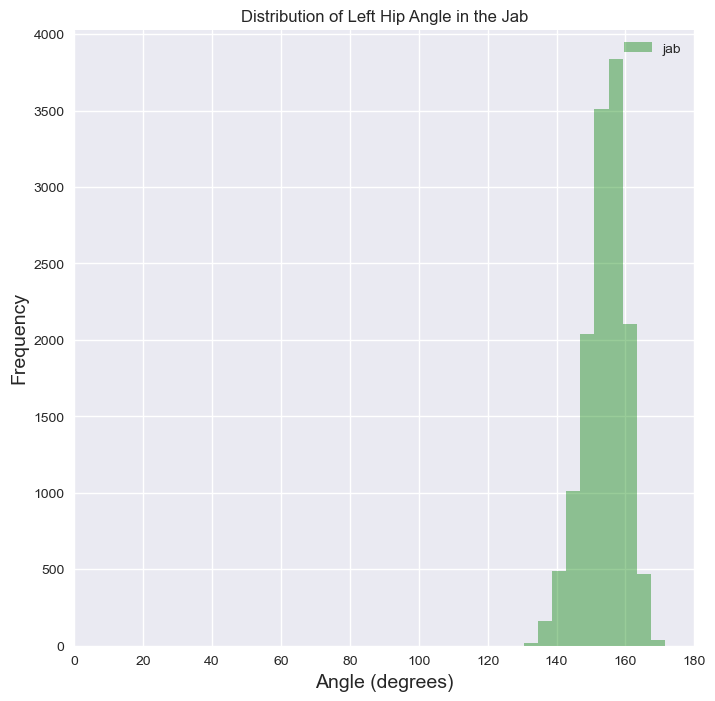

In [110]:
plt.figure(figsize = (8,8))

plt.hist(j['left_hip_angle'], bins = 10, alpha = 0.4, color = 'g', label = j['class'])
plt.xlim(0,180)
plt.xlabel('Angle (degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Left Hip Angle in the Jab')
plt.legend(loc='upper right')

In [111]:
print('For the kick:')
print(f'The range of values for the left hip angle is: {k["left_hip_angle"].min():.2f} to {k["left_hip_angle"].max():.2f} degrees.')



For the kick:
The range of values for the left hip angle is: 5.84 to 179.98 degrees.


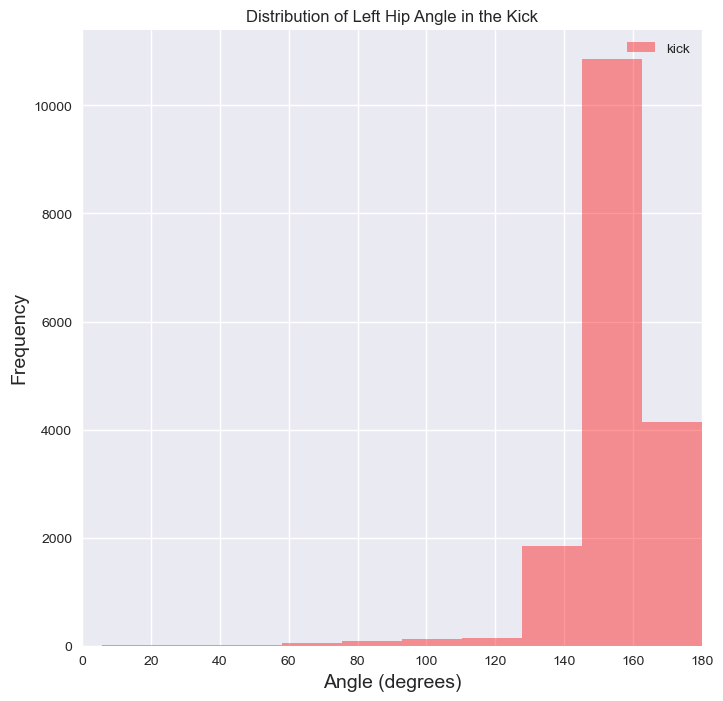

In [112]:
plt.figure(figsize = (8,8))

plt.hist(k['left_hip_angle'], bins = 10, alpha = 0.4, color = 'r', label = k['class'])
plt.xlim(0,180)
plt.xlabel('Angle (degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Left Hip Angle in the Kick')
plt.legend(loc='upper right')

#### Left Knee Angle

In [113]:
print('For the jab:')
print(f'The range of values for the left knee angle is: {j["left_knee_angle"].min():.2f} to {j["left_knee_angle"].max():.2f} degrees.')

For the jab:
The range of values for the left knee angle is: 131.53 to 175.82 degrees.


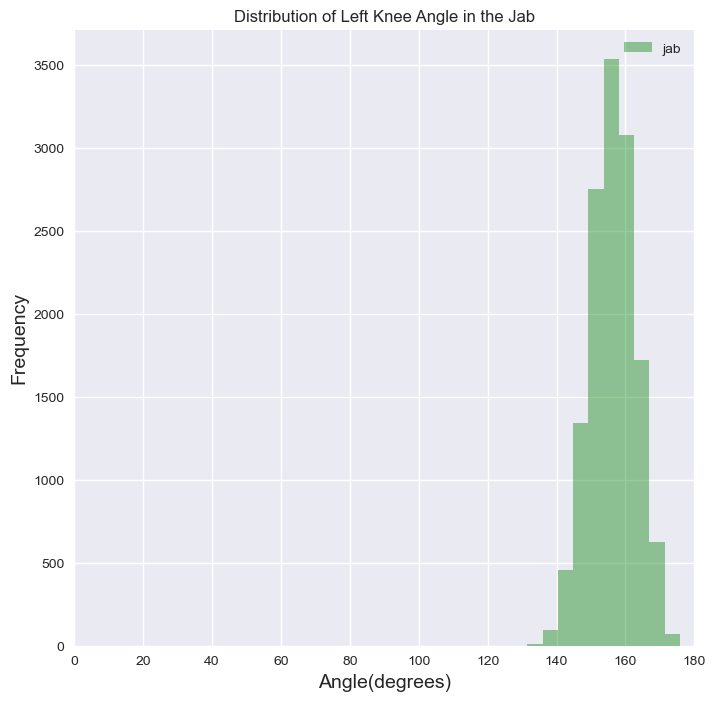

In [114]:
plt.figure(figsize = (8,8))

plt.hist(j['left_knee_angle'], bins = 10, alpha = 0.4, color = 'g', label = j['class'])
plt.xlim(0,180)
plt.xlabel('Angle(degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Left Knee Angle in the Jab')
plt.legend(loc='upper right')

In [115]:
print('For the kick:')
print(f'The range of values for the left knee angle is: {k["left_knee_angle"].min():.2f} to {k["left_knee_angle"].max():.2f} degrees.')



For the kick:
The range of values for the left knee angle is: 0.98 to 179.99 degrees.


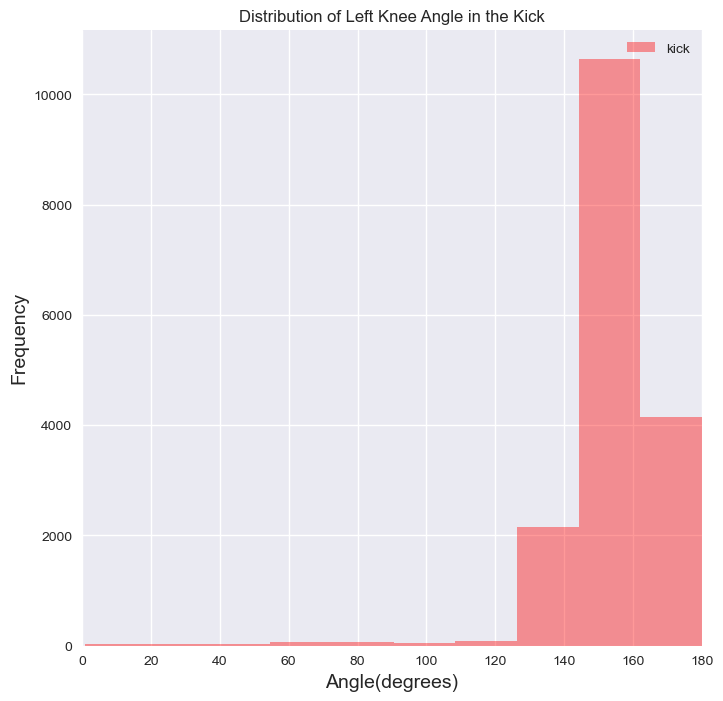

In [116]:
plt.figure(figsize = (8,8))

plt.hist(k['left_knee_angle'], bins = 10, alpha = 0.4, color = 'r', label = k['class'])
plt.xlim(0,180)
plt.xlabel('Angle(degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Left Knee Angle in the Kick')
plt.legend(loc='upper right')

#### Right Elbow Angle

In [117]:
print('For the jab:')
print(f'The range of values for the right elbow angle is: {j["right_elbow_angle"].min():.2f} to {j["right_elbow_angle"].max():.2f} degrees.')



For the jab:
The range of values for the right elbow angle is: 0.02 to 179.98 degrees.


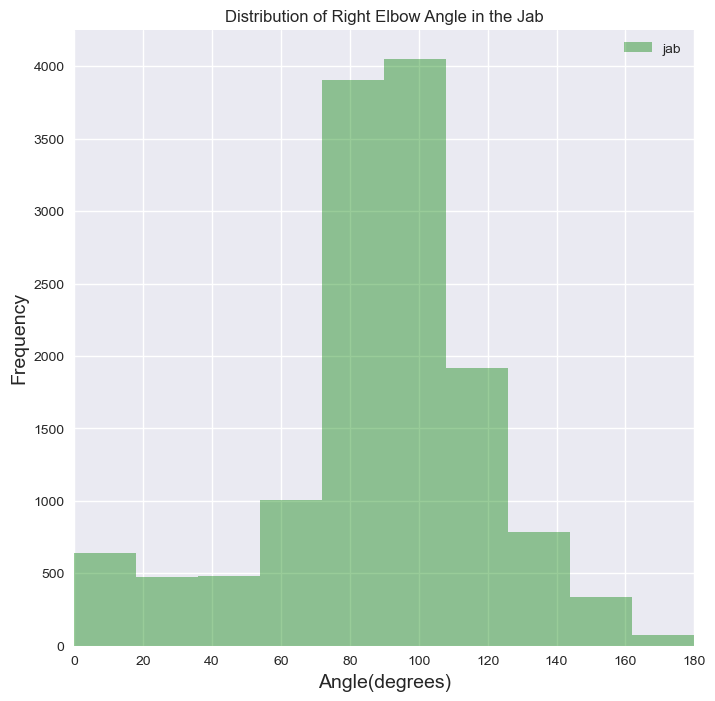

In [118]:
plt.figure(figsize = (8,8))

plt.hist(j['right_elbow_angle'], bins = 10, alpha = 0.4, color = 'g', label = j['class'])
plt.xlim(0,180)
plt.xlabel('Angle(degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Right Elbow Angle in the Jab')
plt.legend(loc='upper right')

In [119]:
print('For the kick:')
print(f'The range of values for the right elbow angle is: {k["right_elbow_angle"].min():.2f} to {k["right_elbow_angle"].max():.2f} degrees.')



For the kick:
The range of values for the right elbow angle is: 0.00 to 179.97 degrees.


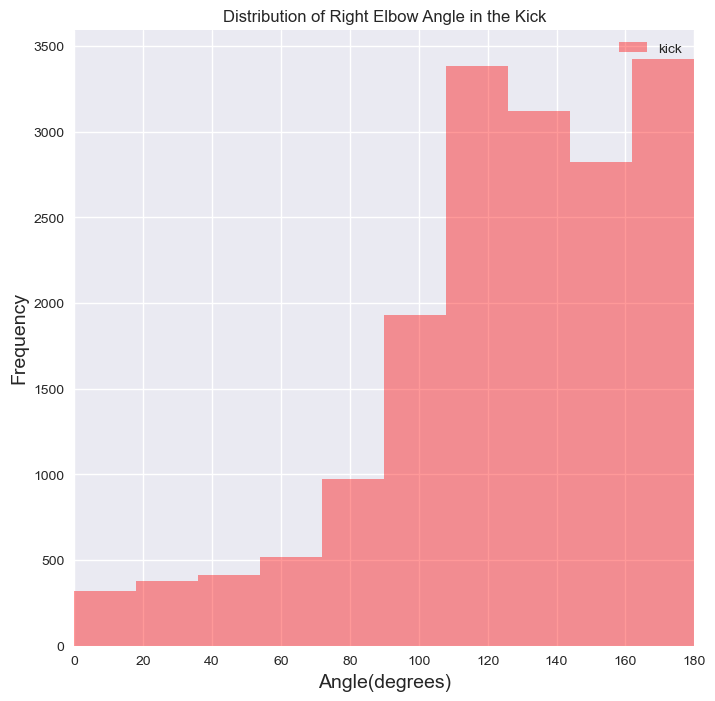

In [120]:
plt.figure(figsize = (8,8))

plt.hist(k['right_elbow_angle'], bins = 10, alpha = 0.4, color = 'r', label = k['class'])
plt.xlim(0,180)
plt.xlabel('Angle(degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Right Elbow Angle in the Kick')
plt.legend(loc='upper right')

#### Right Hip Angle

In [121]:
print('For the jab:')
print(f'The range of values for the right hip angle is: {j["right_hip_angle"].min():.2f} to {j["right_hip_angle"].max():.2f} degrees.')


For the jab:
The range of values for the right hip angle is: 144.05 to 180.00 degrees.


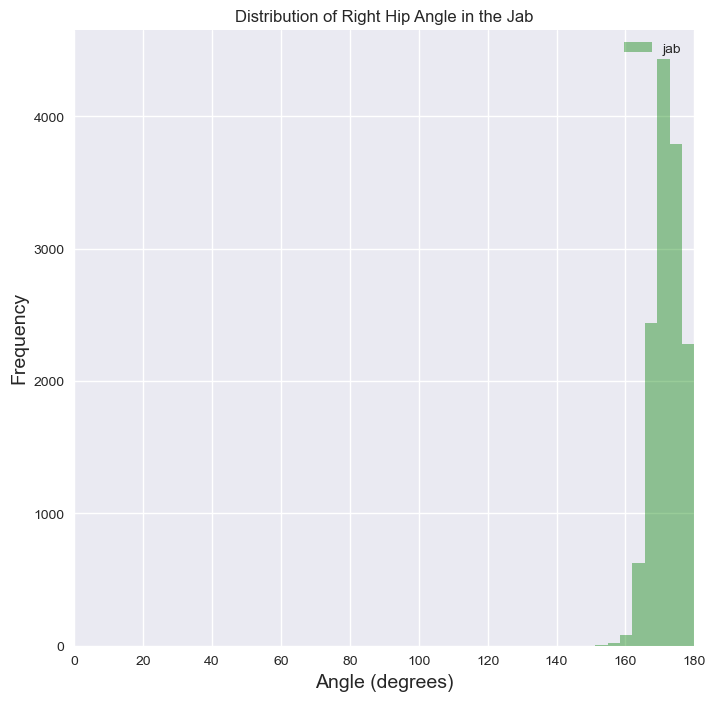

In [122]:
plt.figure(figsize = (8,8))

plt.hist(j['right_hip_angle'], bins = 10, alpha = 0.4, color = 'g', label = j['class'])
plt.xlim(0,180)
plt.xlabel('Angle (degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Right Hip Angle in the Jab')
plt.legend(loc='upper right')

In [123]:
print('For the kick:')
print(f'The range of values for the right hip angle is: {k["right_hip_angle"].min():.2f} to {k["right_hip_angle"].max():.2f} degrees.')


For the kick:
The range of values for the right hip angle is: 0.16 to 180.00 degrees.


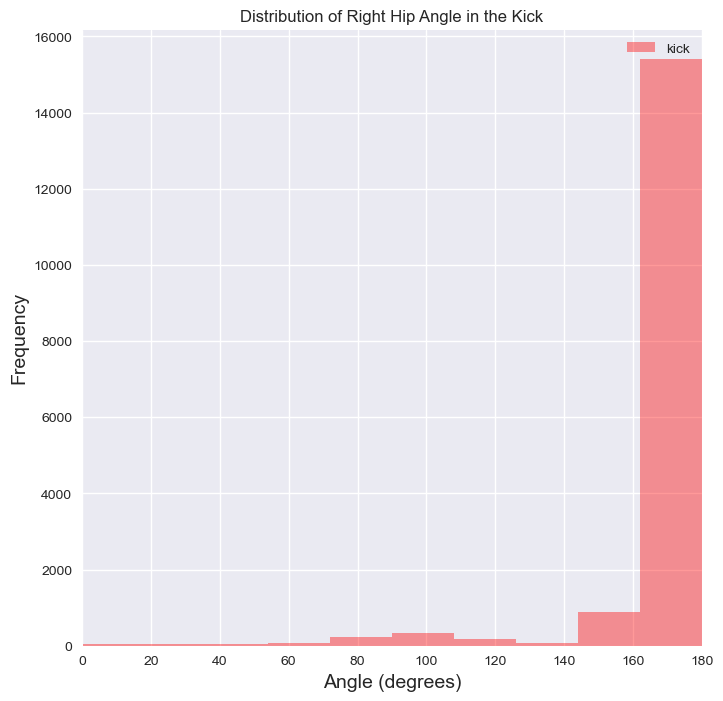

In [124]:
plt.figure(figsize = (8,8))

plt.hist(k['right_hip_angle'], bins = 10, alpha = 0.4, color = 'r', label = k['class'])
plt.xlim(0,180)
plt.xlabel('Angle (degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Right Hip Angle in the Kick')
plt.legend(loc='upper right')

#### Right Knee Angle

In [125]:
print('For the jab:')
print(f'The range of values for the right knee angle is: {j["right_knee_angle"].min():.2f} to {j["right_knee_angle"].max():.2f} degrees.')

For the jab:
The range of values for the right knee angle is: 111.80 to 179.30 degrees.


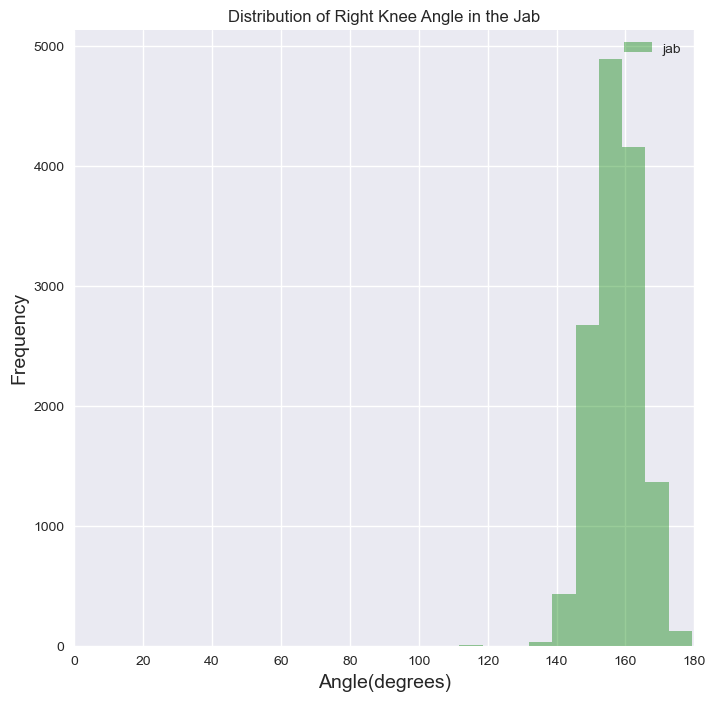

In [126]:
plt.figure(figsize = (8,8))

plt.hist(j['right_knee_angle'], bins = 10, alpha = 0.4, color = 'g', label = j['class'])
plt.xlim(0,180)
plt.xlabel('Angle(degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Right Knee Angle in the Jab')
plt.legend(loc='upper right')

In [127]:
print('For the kick:')
print(f'The range of values for the right knee angle is: {k["right_knee_angle"].min():.2f} to {k["right_knee_angle"].max():.2f} degrees.')

For the kick:
The range of values for the right knee angle is: 0.35 to 180.00 degrees.


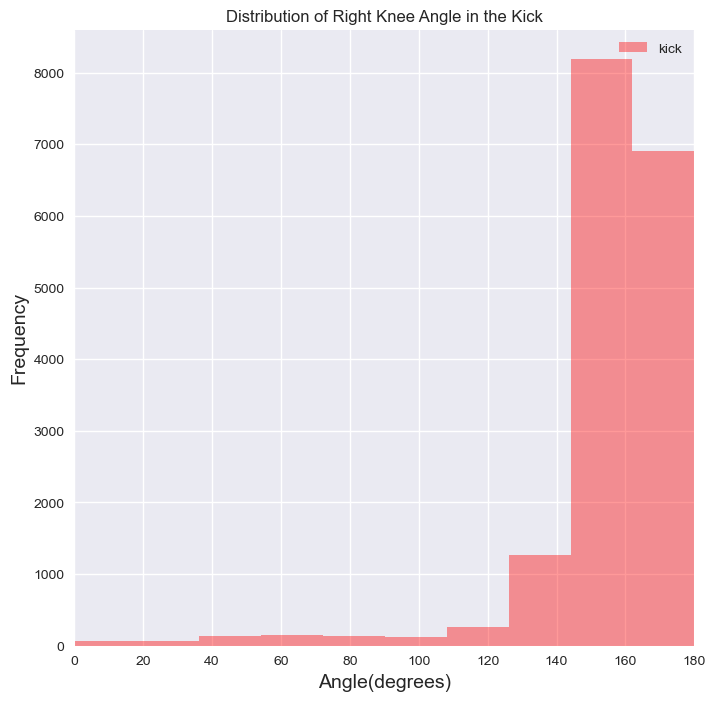

In [128]:
plt.figure(figsize = (8,8))

plt.hist(k['right_knee_angle'], bins = 10, alpha = 0.4, color = 'r', label = k['class'])
plt.xlim(0,180)
plt.xlabel('Angle(degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Right Knee Angle in the Kick')
plt.legend(loc='upper right')

### D - Distances

<a id='distances'></a>

#### Left Ankle-Right Ankle Distance

In [129]:
print('For the jab:')
print(f'The range of values for the distance between the left ankle and right ankle is: {j["left_ankle_right_ankle"].min():.2f} to {j["left_ankle_right_ankle"].max():.2f}.')

For the jab:
The range of values for the distance between the left ankle and right ankle is: 0.05 to 0.11.


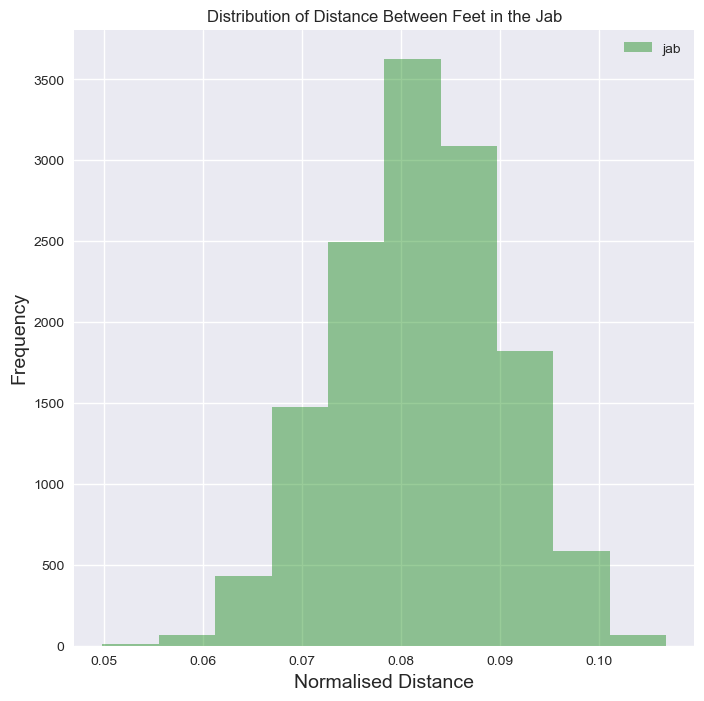

In [130]:
plt.figure(figsize = (8,8))

plt.hist(j['left_ankle_right_ankle'], bins = 10, alpha = 0.4, color = 'g', label = j['class'])
plt.xlabel('Normalised Distance', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Distance Between Feet in the Jab')
plt.legend(loc='upper right')

In [131]:
print('For the kick:')
print(f'The range of values for the distance between the left ankle and right ankle is: {k["left_ankle_right_ankle"].min():.2f} to {k["left_ankle_right_ankle"].max():.2f}.')



For the kick:
The range of values for the distance between the left ankle and right ankle is: 0.00 to 0.41.


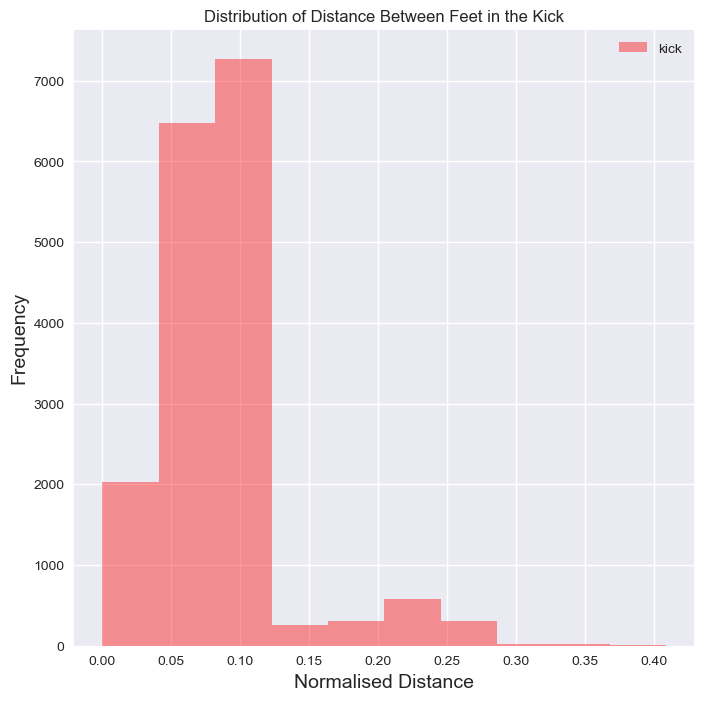

In [132]:
plt.figure(figsize = (8,8))

plt.hist(k['left_ankle_right_ankle'], bins = 10, alpha = 0.4, color = 'r', label = k['class'])
plt.xlabel('Normalised Distance', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Distance Between Feet in the Kick')
plt.legend(loc='upper right')

#### Left Eye-Left Wrist Distance

In [133]:
print('For the jab:')
print(f'The range of values for the distance between the left eye and left wrist is: {j["left_eye_left_wrist"].min():.2f} to {j["left_eye_left_wrist"].max():.2f}.')



For the jab:
The range of values for the distance between the left eye and left wrist is: 0.01 to 0.14.


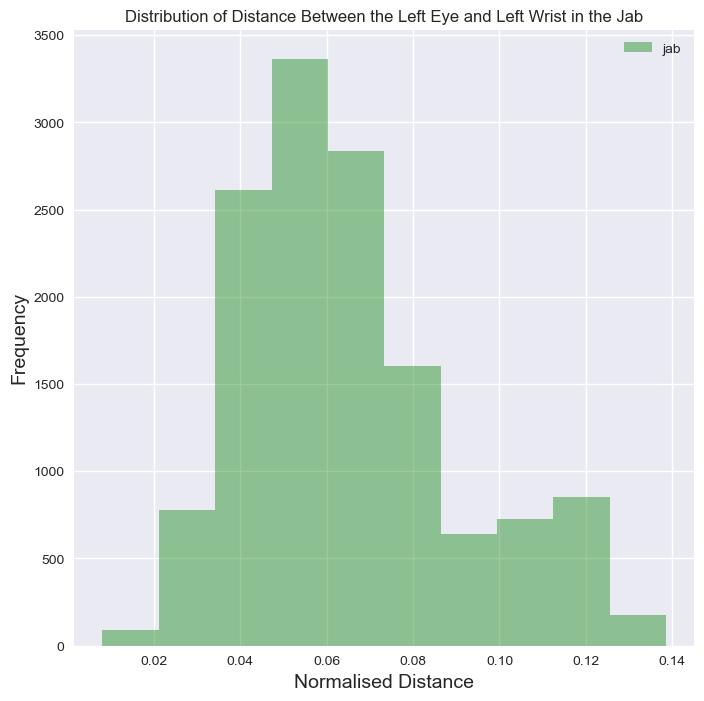

In [134]:
plt.figure(figsize = (8,8))

plt.hist(j['left_eye_left_wrist'], bins = 10, alpha = 0.4, color = 'g', label = j['class'])
plt.xlabel('Normalised Distance', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Distance Between the Left Eye and Left Wrist in the Jab')
plt.legend(loc='upper right')

In [135]:
print('For the kick:')
print(f'The range of values for the distance between the left eye and left wrist is: {k["left_eye_left_wrist"].min():.2f} to {k["left_eye_left_wrist"].max():.2f}.')

For the kick:
The range of values for the distance between the left eye and left wrist is: 0.00 to 0.27.


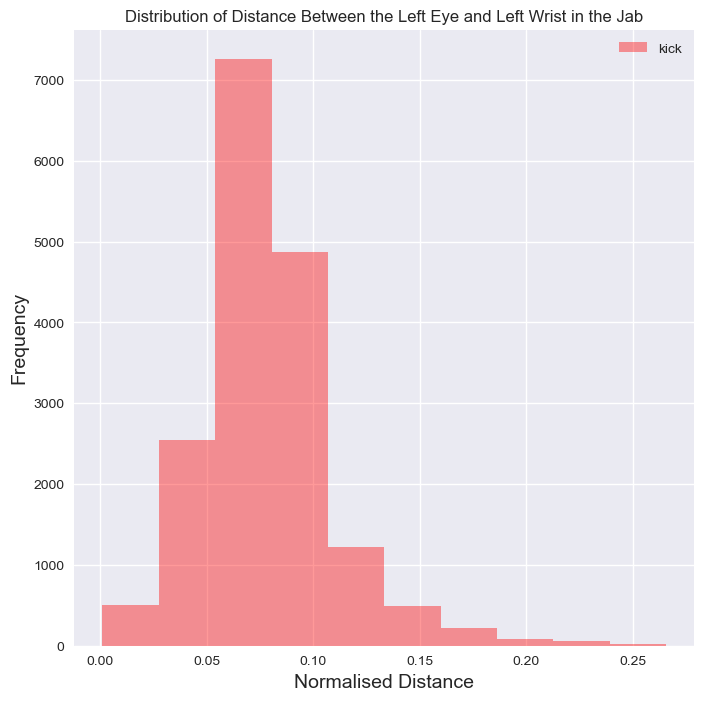

In [136]:
plt.figure(figsize = (8,8))

plt.hist(k['left_eye_left_wrist'], bins = 10, alpha = 0.4, color = 'r', label = k['class'])
plt.xlabel('Normalised Distance', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Distance Between the Left Eye and Left Wrist in the Jab')
plt.legend(loc='upper right')

[Back to start of EDA](#eda)

[Back to top](#part_iii)

## 4. Summary of Findings

<a id='eda_summary'></a>

Including the EDA from the previous chapter, these are most likely the rules that distinguish the three classes:

`guard`

* Range of values for the left wrist x coordinates is: 0.50 - 0.60.
* Range of values for the right ankle y coordinates is: 0.62 to 0.65.

* Range of values for the left elbow angle is: 85 - 95 degrees.
* Range of values for the left hip angle is: 140 to 160 degrees.
* Range of values for the right hip angle is: 140 to 160 degrees.

* Range of values for the distance between the left eye and left wrist is: 0.00 to 0.06.
* Range of values for the distance between the left ankle and right ankle is: 0.05 to 0.11.

`jab`

* Range of values for the left wrist x coordinates is: 0.30 to 0.50.
* Range of values for the left elbow angle is: 160 - 180 degrees. 

`kick`

* Range of values for the right ankle y coordinates is: less than 0.30.
* Range of values for the distance between the left ankle and right ankle is: more than 0.15. 
* Range of values for the right hip angle is: 90 to 110 degrees.

## 5. Unsupervised Learning

<a id='unsup'></a>

In [25]:
# back to using the combined df with both classes, but I'll rename it to C for combined
C = df.drop('class', axis = 1)

In [26]:
# Select n_neighbours = (chosen value for min_samples) - 1
nn = NearestNeighbors(n_neighbors=18)
nn_model = nn.fit(C)

# The distance variable contains an array of 
# distances between a data point and its nearest data point for all data points in data set
distances, indices = nn_model.kneighbors(C)

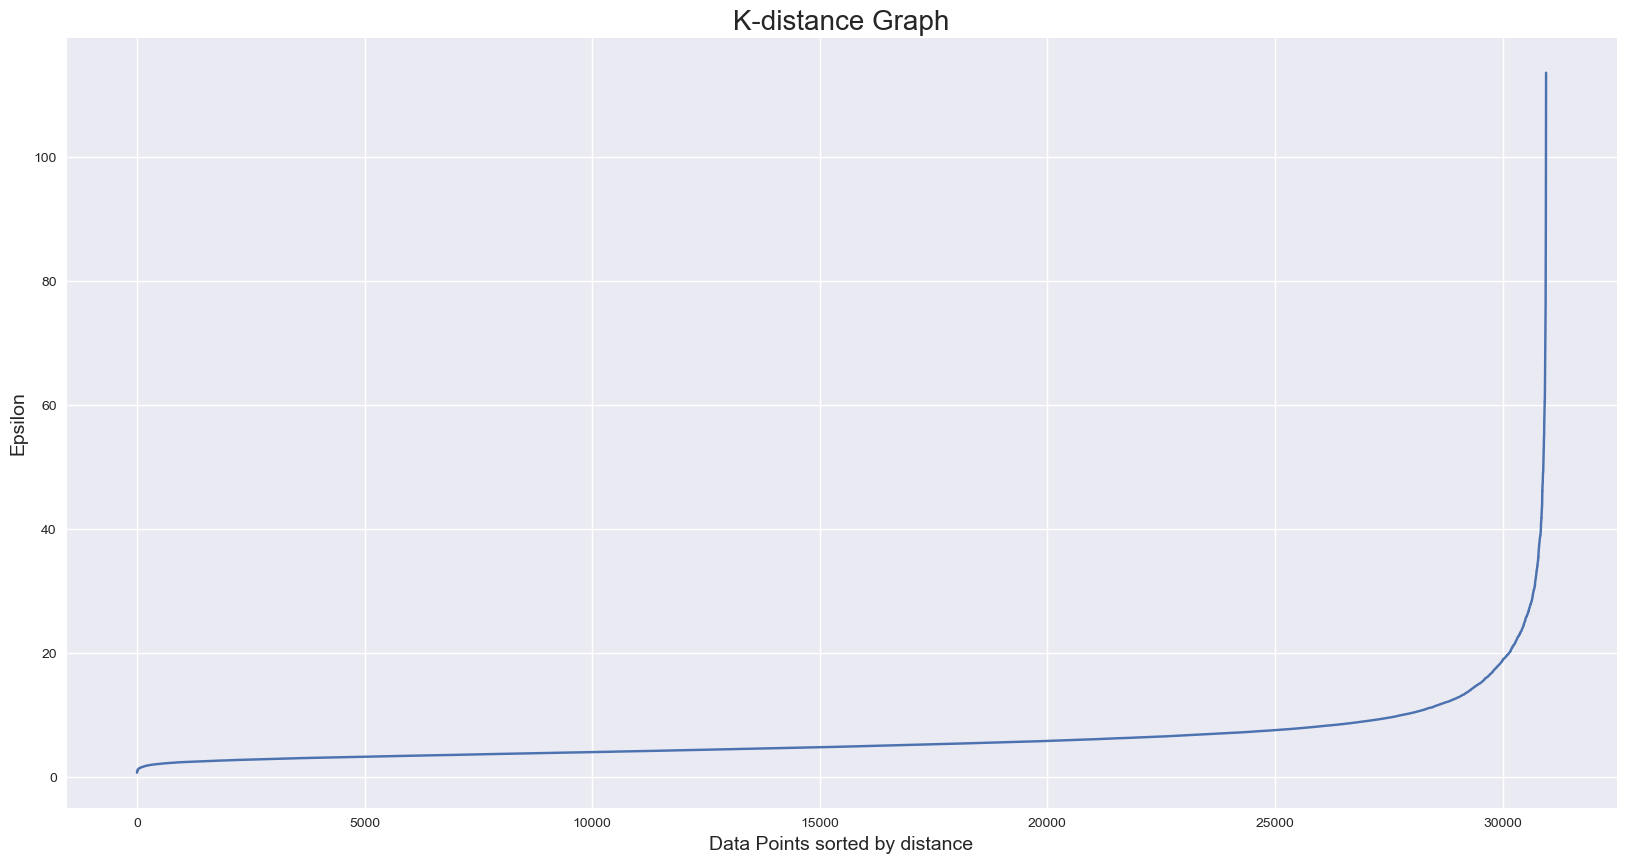

In [27]:
# Plot K-distance graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [28]:
model = DBSCAN(eps=100, min_samples=500).fit(C)

In [29]:
# goal is to check if prop of data points that are outliers are <= 5%
outliers_df = pd.DataFrame(C)

# display the total number of points for each label
print(Counter(model.labels_))

outliers_df['labels'] = model.labels_
outliers_df[outliers_df['labels']==-1].head()

Counter({0: 30865, -1: 90})


nose_y    nose_x  nose_conf  left_eye_y  left_eye_x  left_eye_conf  \
13751  0.313824  0.536655   0.305467    0.301154    0.543680       0.324549   
13753  0.312751  0.544022   0.386458    0.306800    0.545784       0.476003   
13754  0.300240  0.544160   0.261212    0.297391    0.544573       0.317451   
13755  0.329818  0.557340   0.297267    0.318138    0.560673       0.284398   
13756  0.320461  0.551311   0.242306    0.293261    0.543369       0.384587   

       right_eye_y  right_eye_x  right_eye_conf  left_ear_y  ...  \
13751     0.302299     0.536440        0.320470    0.305134  ...   
13753     0.303166     0.547339        0.340035    0.319557  ...   
13754     0.294468     0.545104        0.275603    0.303234  ...   
13755     0.313600     0.554535        0.208727    0.343906  ...   
13756     0.292782     0.542200        0.317758    0.333187  ...   

       left_elbow_angle  left_hip_angle  left_knee_angle  right_elbow_angle  \
13751        107.543582      172.549120        47.163460         115.707375   
13753         85.097444       11.437561         5.782142         120.818232   
13754         93.622593       23.300422         8.303081          66.931571   
13755         73.508584       14.202254         4.028571         140.099509   
13756         26.024760        5.835546        17.746766          90.553691   

       right_hip_angle  right_knee_angle  left_eye_left_wrist  \
13751        41.381625         39.830736             0.014007   
13753         4.170950          3.310203             0.062260   
13754        20.640001          8.293693             0.061184   
13755         9.640992          8.959151             0.032035   
13756         3.163893         12.697535             0.064297   

       right_eye_right_wrist  left_ankle_right_ankle  labels  
13751               0.032794                0.023062      -1  
13753               0.032436                0.008088      -1  
13754               0.003161                0.011545      -1  
13755               0.047501                0.041873      -1  
13756               0.012017                0.012469      -1  

[5 rows x 61 columns]

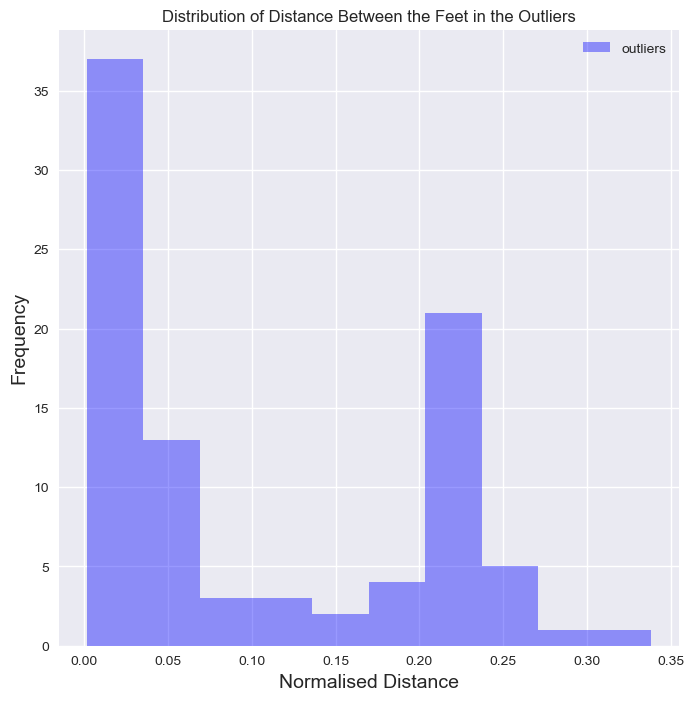

In [30]:
plt.figure(figsize = (8,8))

plt.hist(outliers_df[outliers_df['labels']==-1]['left_ankle_right_ankle'], bins = 10, alpha = 0.4, color = 'b', label = 'outliers')
plt.xlabel('Normalised Distance', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Distance Between the Feet in the Outliers')
plt.legend(loc='upper right')

#### Interpreting Results

Records with label = -1 are considered outliers 
* 90 out of 30955 total observations have label = -1
* This translates into an outlier proportion of 0.29% which is very very low
* However it is not identifying more than 1 class

Text(0.5, 1.0, 'DBSCAN for Outlier Detection')

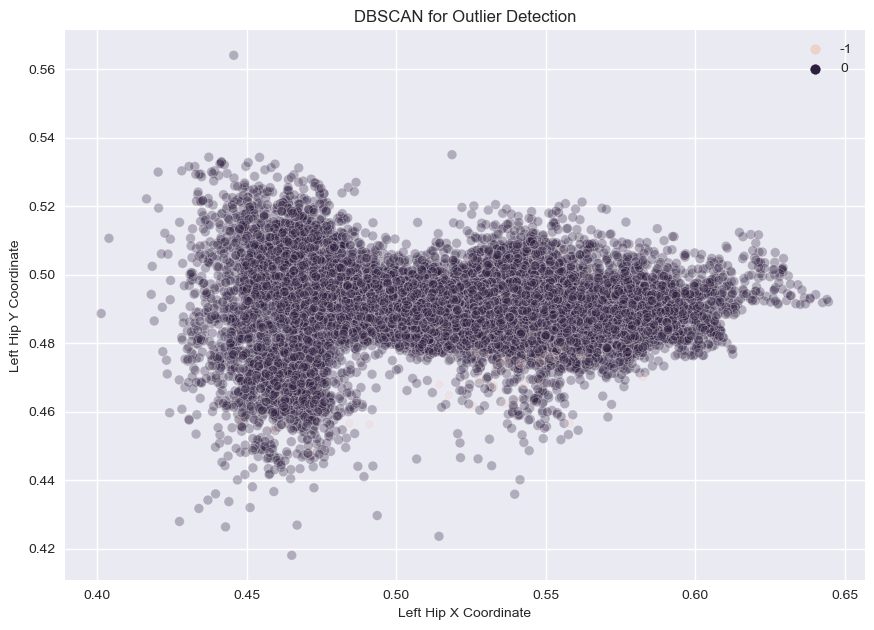

In [31]:
# create visualisation of clustering results
fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])

# display scatter plot at column index = 2 and column index = 1
# c refers to label colours which equal to model labels in this case
# s refers to the size of the scatter plot
sns.scatterplot(x = C['left_hip_x'], y = C['left_hip_y'], alpha = 0.3, hue = model.labels_)

# set labels for axes
ax.set_xlabel('Left Hip X Coordinate')
ax.set_ylabel('Left Hip Y Coordinate')

# set title fror scatter plot
plt.title('DBSCAN for Outlier Detection')

In [32]:
# Instantiate a clustering object with a pre-determined number of clusters
clustering = KMeans(n_clusters=2, max_iter=500, random_state=5)

# fit model to data set and learn its statistical parameters (mean, variance)
# apply kmeans clustering with 3 clusters to the input data from X
# clustering itself happens with the fit method
clustering.fit(C)

KMeans(max_iter=500, n_clusters=2, random_state=5)

In [64]:
clustering.fit_predict(C)
score = silhouette_score(C, clustering.labels_, metric='euclidean')
score

0.3457329275013615

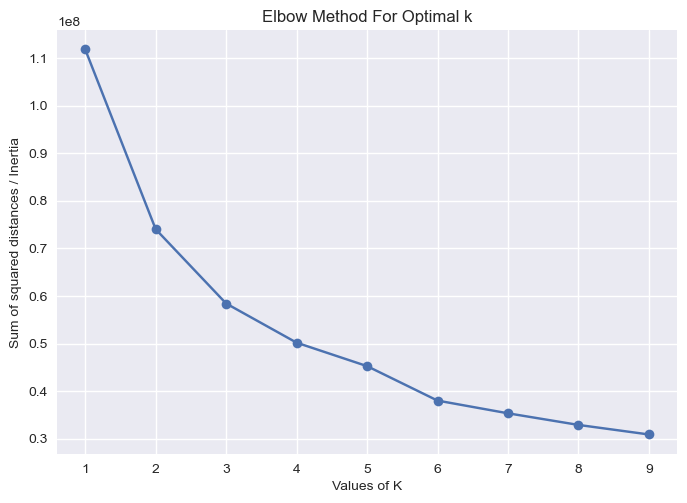

In [65]:
sum_of_squared_distances = []
# k means the number of clusters
# typically it is in the single digit range
# this range of values to test for k below is completely arbitrary 
# but works well (from experience) with most cases
K = range(1,10)

for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(C)
    
    # Inertia tells how far away the points within a cluster are. Therefore, a small of inertia is aimed for
    # Inertia can range from zero to infinity
    sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(K,sum_of_squared_distances, marker='o')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances / Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

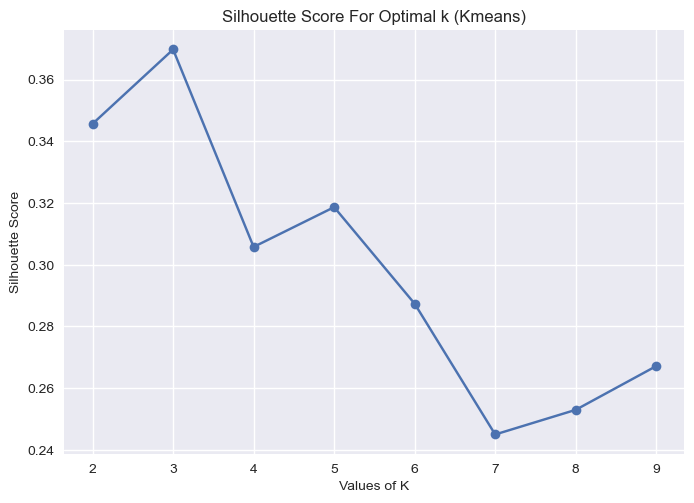

In [66]:
silhouette_avg_n_clusters = []
# k means the number of clusters
# typically it is in the single digit range
# this range of values to test for k below is completely arbitrary 
# but works well (from experience) with most cases
K = range(2,10)

for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit_predict(C)
    score = silhouette_score(C, kmeans.labels_, metric='euclidean')

    silhouette_avg_n_clusters.append(score)

    
plt.plot(K, silhouette_avg_n_clusters, marker='o')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('Silhouette Score For Optimal k (Kmeans)')
plt.show()

In [67]:
# update with ideal value of K
kmeans = KMeans(n_clusters= 3)
kmeans.fit_predict(C)
score = silhouette_score(C, kmeans.labels_, metric='euclidean')
print('Silhouette Score:', score)

Silhouette Score: 0.3698700166967511


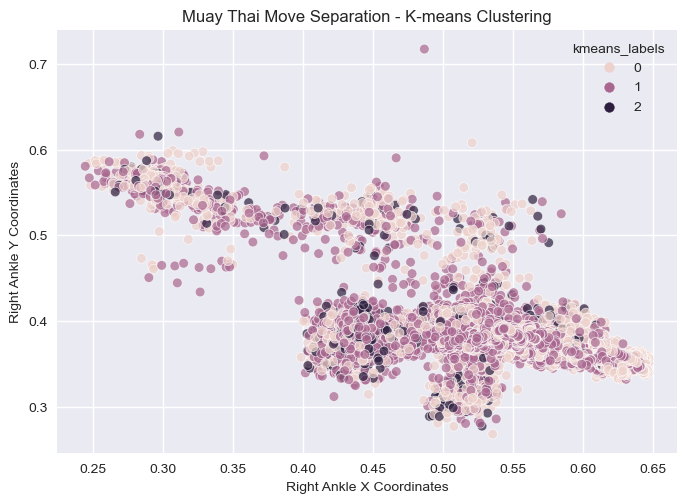

In [68]:
# Assign the cluster labels to the original dataset
C['kmeans_labels'] = kmeans.labels_

# Visualize the clusters using scatter plots
sns.scatterplot(x = C['right_ankle_x'], y = 1 - C['right_ankle_y'], alpha = 0.7, hue = C['kmeans_labels'])
plt.xlabel('Right Ankle X Coordinates')
plt.ylabel('Right Ankle Y Coordinates')
plt.title('Muay Thai Move Separation - K-means Clustering')

plt.show()

In [69]:
C['kmeans_labels'].value_counts()

0    15842
1    12071
2     3042
Name: kmeans_labels, dtype: int64

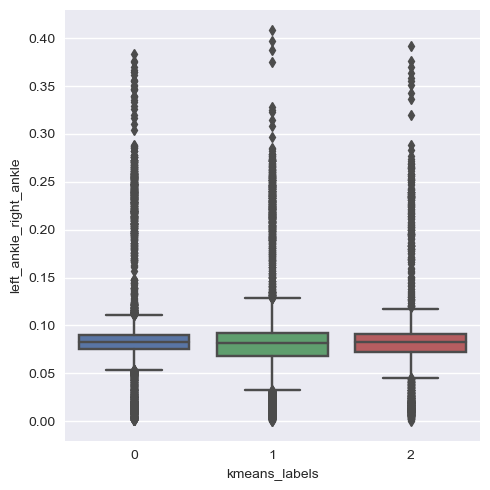

In [70]:
sns.catplot(data=C, x="kmeans_labels", y="left_ankle_right_ankle", kind="box", orient = 'v')

In [71]:
Z = linkage(C, 'ward')

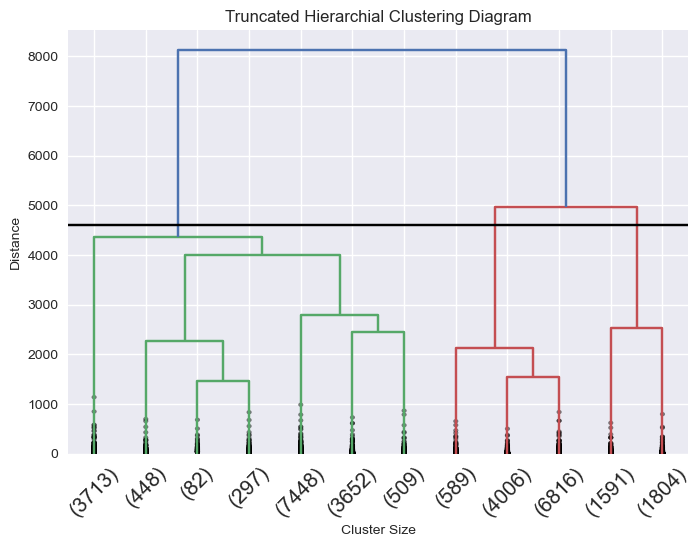

In [72]:
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15, show_contracted=True)

plt.title('Truncated Hierarchial Clustering Diagram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')

# create horizontal lines on the plot
plt.axhline(y=4600, color = 'black')


# display dendogram
plt.show()

In [73]:
C.drop(['labels','kmeans_labels'], axis = 1, inplace=True)

In [74]:
# Set k = 3, since Y variable consists of only 3 classes: guard, jab, or kick
k=3

# create hierarchical clustering object
Hclustering = AgglomerativeClustering(n_clusters=k)
Hclustering.fit(C)

# The labels_ property returns an array of integers where the values correspond to the distinct categories
labels = Hclustering.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [75]:
np.unique(labels)

array([0, 1, 2])

### Visualise Clusters

In [76]:
C['labels'] = list(labels)

In [77]:
C['labels'].value_counts()

1    15249
0    13699
2     2007
Name: labels, dtype: int64

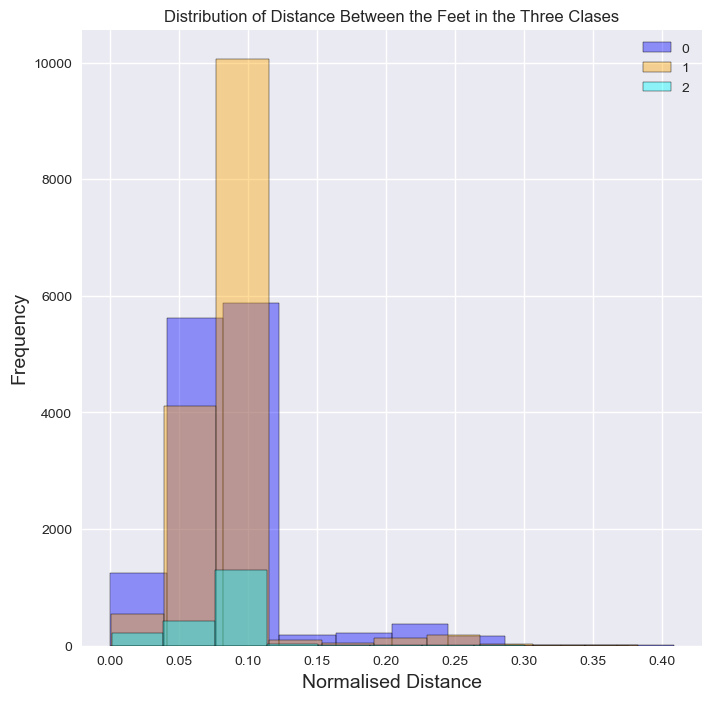

In [78]:
plt.figure(figsize = (8,8))

sns.histplot(C[C['labels']==0]['left_ankle_right_ankle'], bins = 10, alpha = 0.4, color = 'blue', label = '0')
sns.histplot(C[C['labels']==1]['left_ankle_right_ankle'], bins = 10, alpha = 0.4, color = 'orange', label = '1')
sns.histplot(C[C['labels']==2]['left_ankle_right_ankle'], bins = 10, alpha = 0.4, color = 'cyan', label = '2')
plt.xlabel('Normalised Distance', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Distance Between the Feet in the Three Clases')
plt.legend(loc='upper right')

## 6. Identification of the 3 Classes

<a id='classes'></a>

In [33]:
X = C.drop('labels', axis = 1)
y = C['labels']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

In [81]:
y_test

12284    1
15667    1
17243    0
13793    1
25541    0
        ..
29529    0
10920    1
12463    1
8759     1
3821     2
Name: labels, Length: 9287, dtype: int64

In [82]:
# Logistic Regression
steps = [['smote', SMOTE(random_state = 42)],
         ('ss', StandardScaler()),
        ('lr', LogisticRegression(solver='liblinear'))]
lr_pipe = Pipeline(steps)

lr_params = {'lr__C': [0.1, 0.5, 1, 5, 10], 
            'lr__penalty': ['l1', 'l2']}

lr = GridSearchCV(lr_pipe, param_grid=lr_params, cv=5)


In [83]:
lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=42)],
                                       ('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'lr__C': [0.1, 0.5, 1, 5, 10],
                         'lr__penalty': ['l1', 'l2']})

In [84]:
lr.best_params_

{'lr__C': 10, 'lr__penalty': 'l1'}

In [85]:
# Making predictions
y_lr_pred = lr.predict(X_test)
y_lr_pred_proba = lr.predict_proba(X_test)

In [86]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(9287, 3)

In [87]:
pred_prob_train = lr.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train, 
                                multi_class="ovr", average="micro")
pred_prob_test = lr.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test, 
                                multi_class="ovr", average="micro")

print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')


print(classification_report(y_test, y_lr_pred))

ROC-AUC on training set: 0.9925552248289243
ROC-AUC on testing set: 0.9911761287914905
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      4111
           1       0.95      0.94      0.95      4573
           2       0.84      0.97      0.90       603

    accuracy                           0.94      9287
   macro avg       0.91      0.95      0.93      9287
weighted avg       0.94      0.94      0.94      9287



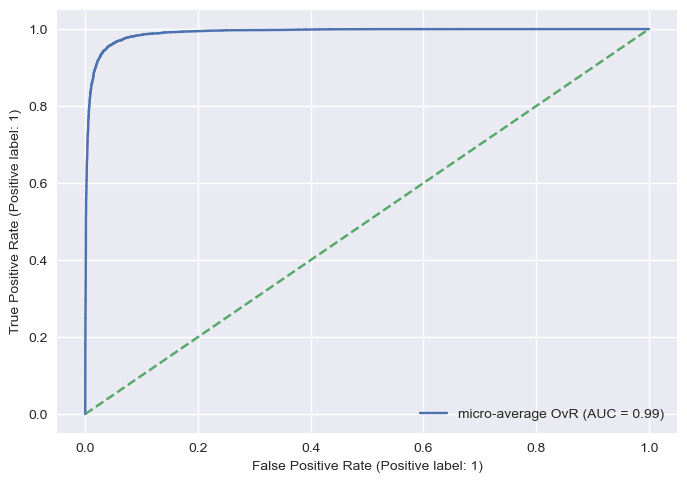

In [88]:
roc_display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_lr_pred_proba.ravel(),
    name="micro-average OvR"
)


plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

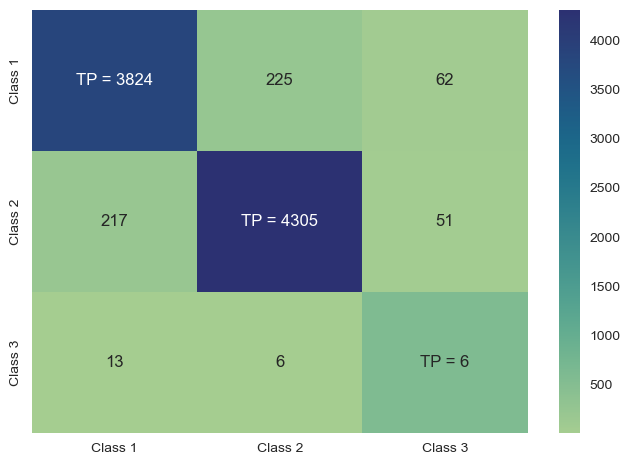

In [89]:
# plot confusion matrix heatmap
cm = confusion_matrix(y_test,lr.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TP = ' + str(value[0]), str(value[1]), str(value[2])])
    elif index == 1:
        cm_label.append([str(value[0]), 'TP = ' + str(value[1]), str(value[2])])
    else:
        cm_label.append([str(value[0]), str(value[1]), 'TP = ' + str(value[1])])
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['Class 1','Class 2', 'Class 3'],
    yticklabels=['Class 1','Class 2', 'Class 3']
)

In [90]:
coef = lr.best_estimator_['lr'].coef_[0]
feature = lr.best_estimator_['ss'].get_feature_names_out()

<Axes: xlabel='Importance', ylabel='Features'>

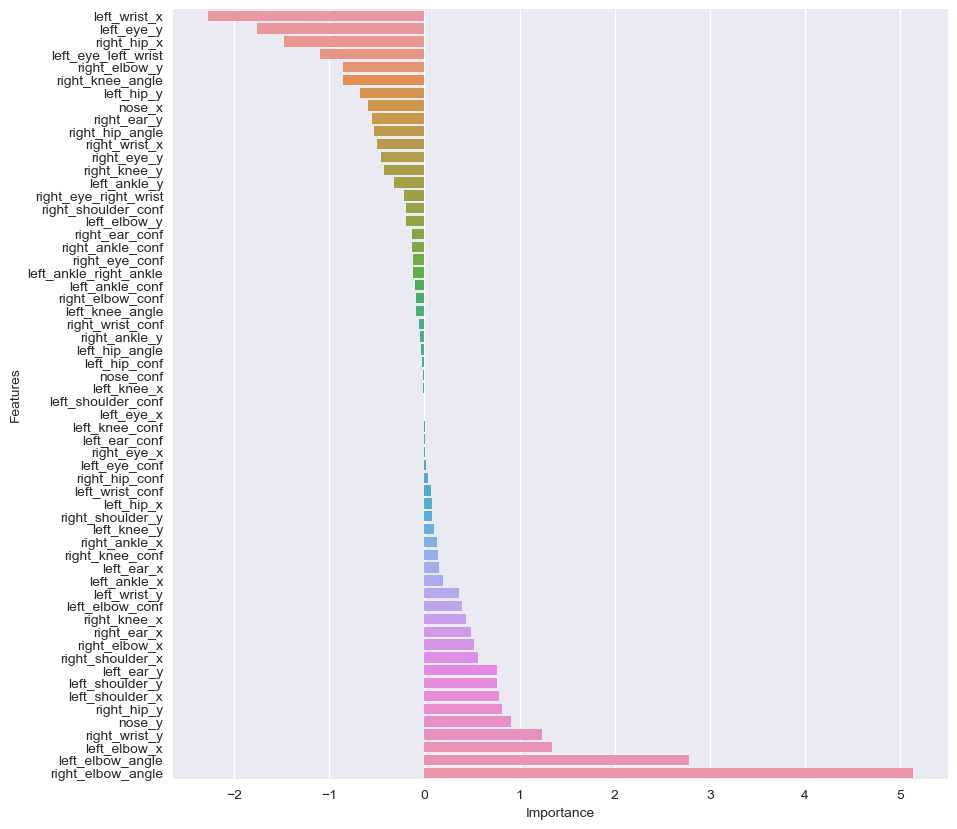

In [91]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(50, 'Importance')
bottom_features = feature_importance.nsmallest(50, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

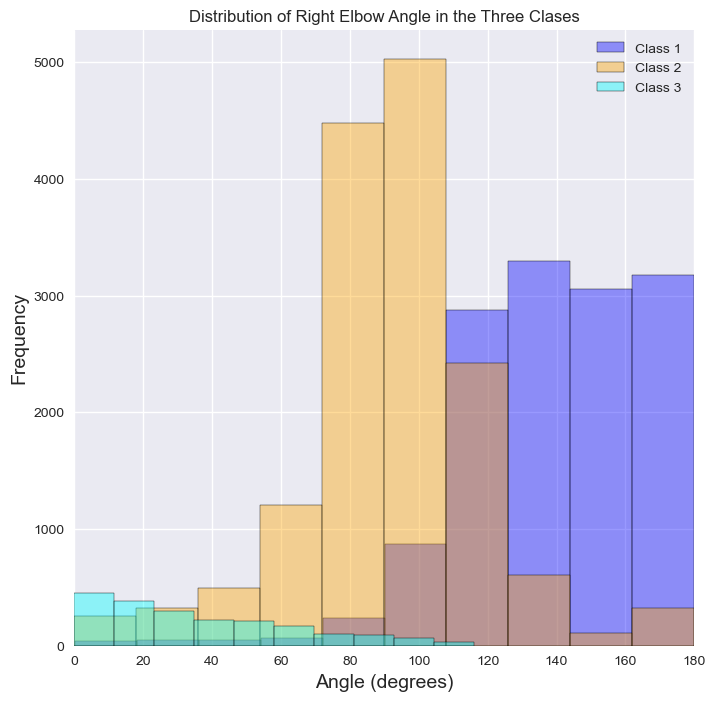

In [92]:
plt.figure(figsize = (8,8))

sns.histplot(C[C['labels']==0]['right_elbow_angle'], bins = 10, alpha = 0.4, color = 'blue', label = 'Class 1')
sns.histplot(C[C['labels']==1]['right_elbow_angle'], bins = 10, alpha = 0.4, color = 'orange', label = 'Class 2')
sns.histplot(C[C['labels']==2]['right_elbow_angle'], bins = 10, alpha = 0.4, color = 'cyan', label = 'Class 3')

plt.xlim(0,180)
plt.xlabel('Angle (degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Right Elbow Angle in the Three Clases')
plt.legend(loc='upper right')

Text(0, 0.5, 'Frequency')

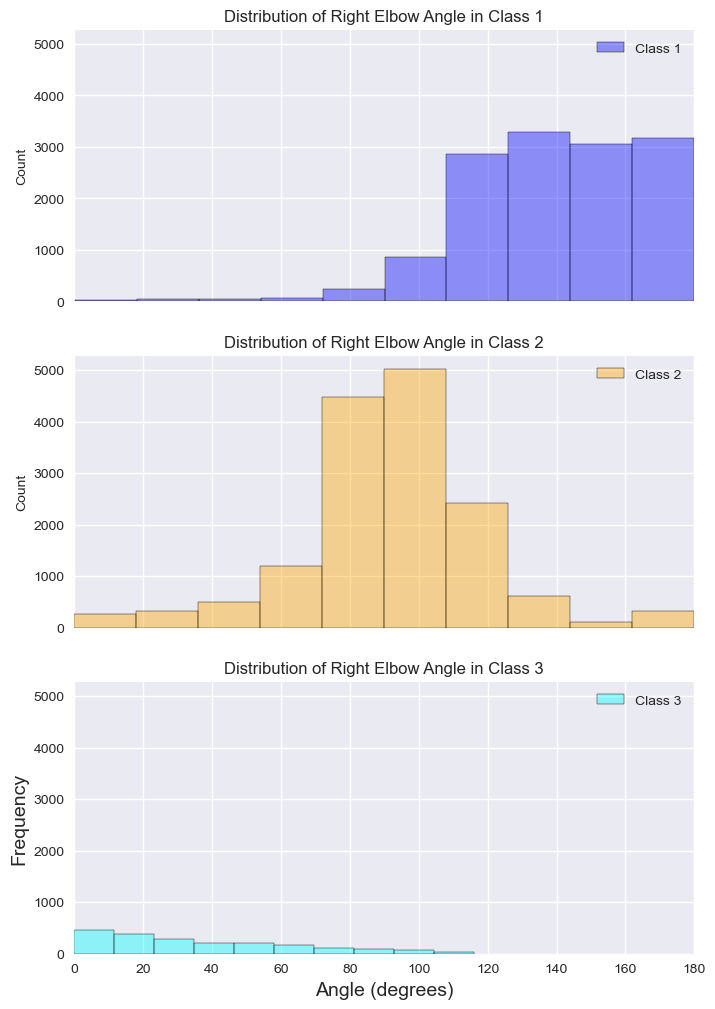

In [93]:
fig, ax = plt.subplots(3,1, figsize = (8,12), sharex = 'all', sharey = 'all')


sns.histplot(C[C['labels']==0]['right_elbow_angle'], ax= ax[0], bins = 10, alpha = 0.4, color = 'blue', label = 'Class 1')
ax[0].set_title('Distribution of Right Elbow Angle in Class 1')
ax[0].legend(loc='upper right')


sns.histplot(C[C['labels']==1]['right_elbow_angle'], ax= ax[1],bins = 10, alpha = 0.4, color = 'orange', label = 'Class 2')
ax[1].set_title('Distribution of Right Elbow Angle in Class 2')
ax[1].legend(loc='upper right')

sns.histplot(C[C['labels']==2]['right_elbow_angle'], ax= ax[2],bins = 10, alpha = 0.4, color = 'cyan', label = 'Class 3')
ax[2].set_title('Distribution of Right Elbow Angle in Class 3')
ax[2].legend(loc='upper right')

plt.xlim(0,180)
plt.xlabel('Angle (degrees)', size=14)
plt.ylabel('Frequency', size=14)



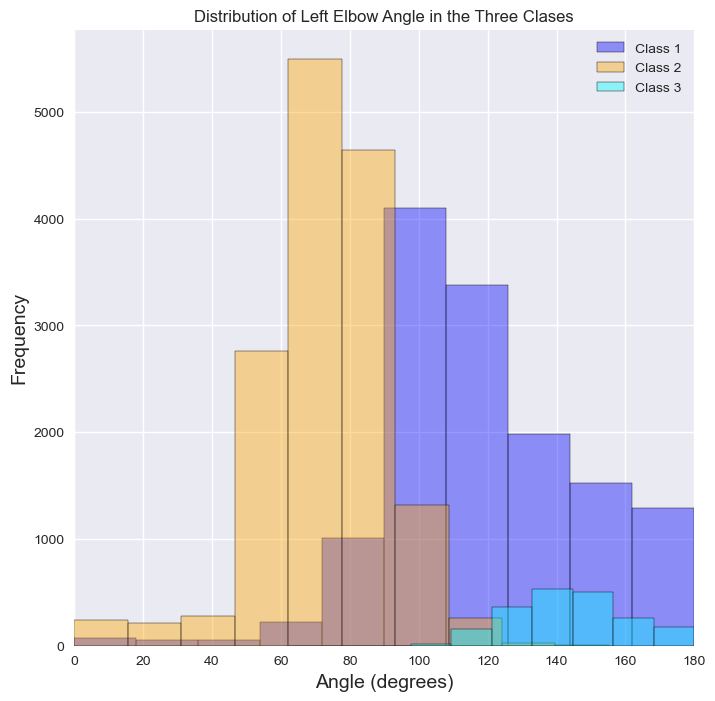

In [94]:
plt.figure(figsize = (8,8))

sns.histplot(C[C['labels']==0]['left_elbow_angle'], bins = 10, alpha = 0.4, color = 'blue', label = 'Class 1')
sns.histplot(C[C['labels']==1]['left_elbow_angle'], bins = 10, alpha = 0.4, color = 'orange', label = 'Class 2')
sns.histplot(C[C['labels']==2]['left_elbow_angle'], bins = 10, alpha = 0.4, color = 'cyan', label = 'Class 3')

plt.xlim(0,180)
plt.xlabel('Angle (degrees)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Left Elbow Angle in the Three Clases')
plt.legend(loc='upper right')

Text(0, 0.5, 'Frequency')

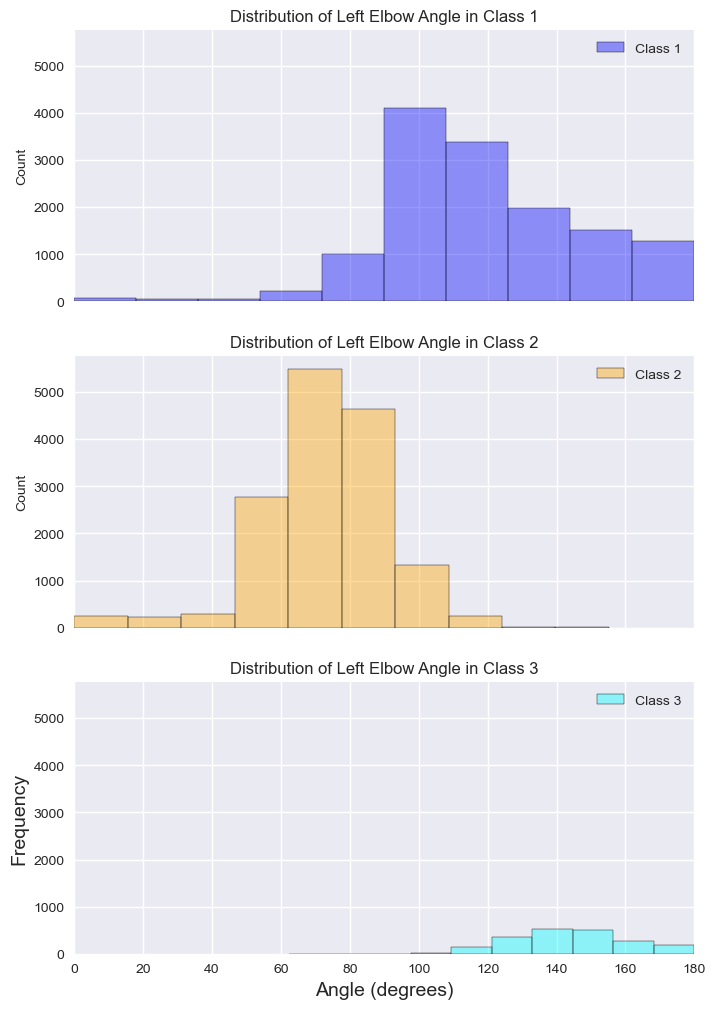

In [95]:
fig, ax = plt.subplots(3,1, figsize = (8,12), sharex = 'all', sharey = 'all')


sns.histplot(C[C['labels']==0]['left_elbow_angle'], ax= ax[0], bins = 10, alpha = 0.4, color = 'blue', label = 'Class 1')
ax[0].set_title('Distribution of Left Elbow Angle in Class 1')
ax[0].legend(loc='upper right')


sns.histplot(C[C['labels']==1]['left_elbow_angle'], ax= ax[1],bins = 10, alpha = 0.4, color = 'orange', label = 'Class 2')
ax[1].set_title('Distribution of Left Elbow Angle in Class 2')
ax[1].legend(loc='upper right')

sns.histplot(C[C['labels']==2]['left_elbow_angle'], ax= ax[2],bins = 10, alpha = 0.4, color = 'cyan', label = 'Class 3')
ax[2].set_title('Distribution of Left Elbow Angle in Class 3')
ax[2].legend(loc='upper right')

plt.xlim(0,180)
plt.xlabel('Angle (degrees)', size=14)
plt.ylabel('Frequency', size=14)



Unfortunately, after studying these two features, I can only conclude that I have been unsuccessful in separating the `jab` and `kick` classes further into `jab`, `kick` and `guard` through unsupervised learning. The three classes here don't seem to correspond obviously with the three classes I was trying to identify. If they did, one class should have a spike in 0 or 180 degrees for only the left_elbow_angle (`jab`), one should have a bump in 0 or 180 degress for left_elbow_angle **and** a spike in 0 or 180 degrees for right_elbow_angle (`kick`), and one should be primarily around 90 degrees for both left and right elbow (`guard`).

Therefore, I should move on to using functions instead to identify the classes. I will do this in the final codebook.

## 7. Manual Creation of the 3 Classes

<a id='classes2'></a>

Based on the results derived in the [EDA summary](#eda_summary) above, I will now manually split the two `jab` and `kick` classes into `jab`, `kick`, and `guard`. 

In [60]:
j_guard = j[(j.left_elbow_angle <= 100)]
j_guard['class'] = 'guard'
j_guard.shape

(10321, 61)

In [63]:
j2 = j[(j.left_elbow_angle > 100)]
j2.shape

(3355, 61)

In [145]:
k_guard = k[(k.right_hip_angle >= 170)]
k_guard['class'] = 'guard'
k_guard.shape

(12200, 61)

In [146]:
k2 = k[(k.right_hip_angle < 170)]
k2.shape

(5079, 61)

In [147]:
true_guard = pd.concat([j_guard, k_guard])
true_guard.shape

(22521, 61)

There are many m ore instances of the `guard` class than of the jab or kick classes, so I will downsample to the average between the number of `jab` and `kick` items.

In [148]:
avg = int((3355 + 5079) / 2)
avg

4217

In [149]:
true_guard_downsample = true_guard.sample(n= avg, random_state=42)

In [150]:
df2 = pd.concat([j2, k2, true_guard_downsample])
df2.shape

(12651, 61)

In [151]:
df2.head()

class    nose_y    nose_x  nose_conf  left_eye_y  left_eye_x  left_eye_conf  \
0   jab  0.358558  0.534928   0.428068    0.349753    0.538562       0.520767   
1   jab  0.354950  0.534928   0.429855    0.344793    0.538798       0.439971   
2   jab  0.356394  0.529715   0.355001    0.347231    0.532894       0.371135   
3   jab  0.361202  0.526561   0.459735    0.350566    0.529534       0.494844   
4   jab  0.365215  0.522697   0.460635    0.354571    0.527073       0.543145   

   right_eye_y  right_eye_x  right_eye_conf  ...  right_ankle_conf  \
0     0.351623     0.536914        0.432593  ...          0.495854   
1     0.346823     0.536408        0.399558  ...          0.514417   
2     0.349044     0.532060        0.344950  ...          0.539205   
3     0.351816     0.528211        0.414252  ...          0.543162   
4     0.356350     0.524791        0.429686  ...          0.579988   

   left_elbow_angle  left_hip_angle  left_knee_angle  right_elbow_angle  \
0        106.869979      152.913695       143.771564         149.295589   
1        117.393998      151.511881       141.011217         146.011644   
2        114.179852      152.091517       145.470803         135.805052   
3        103.070092      157.059965       152.664103         144.276908   
4        102.598005      153.918654       149.486543         113.410012   

   right_hip_angle  right_knee_angle  left_eye_left_wrist  \
0       172.782427        167.232018             0.025881   
1       173.200447        166.980518             0.032847   
2       178.343169        176.407057             0.032203   
3       178.880612        171.694485             0.023898   
4       179.413760        175.163285             0.023089   

   right_eye_right_wrist  left_ankle_right_ankle  
0               0.021182                0.071300  
1               0.021346                0.069487  
2               0.019225                0.077512  
3               0.006186                0.078787  
4               0.004042                0.078559  

[5 rows x 61 columns]

## 8. Testing the New Classes

<a id='test_model'></a>

In [152]:
X = df2.drop('class', axis = 1)
y = df2['class']

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

In [154]:
y_test

20201     kick
23619     kick
28891     kick
7004       jab
21383     kick
         ...  
5971       jab
17881     kick
4041       jab
2829       jab
1274     guard
Name: class, Length: 3796, dtype: object

In [155]:
# Logistic Regression
steps = [['smote', SMOTE(random_state = 42)],
         ('ss', StandardScaler()),
        ('lr', LogisticRegression(solver='liblinear'))]
lr_pipe = Pipeline(steps)

lr_params = {'lr__C': [0.1, 0.5, 1, 5, 10], 
            'lr__penalty': ['l1', 'l2']}

lr = GridSearchCV(lr_pipe, param_grid=lr_params, cv=5)


In [156]:
lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=42)],
                                       ('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'lr__C': [0.1, 0.5, 1, 5, 10],
                         'lr__penalty': ['l1', 'l2']})

In [157]:
lr.best_params_

{'lr__C': 10, 'lr__penalty': 'l1'}

In [158]:
# Making predictions
y_lr_pred = lr.predict(X_test)
y_lr_pred_proba = lr.predict_proba(X_test)

In [159]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(3796, 3)

In [160]:
pred_prob_train = lr.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train, 
                                multi_class="ovr", average="micro")
pred_prob_test = lr.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test, 
                                multi_class="ovr", average="micro")

print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')


print(classification_report(y_test, y_lr_pred))

ROC-AUC on training set: 0.9908390369849137
ROC-AUC on testing set: 0.99091617014638
              precision    recall  f1-score   support

       guard       0.92      0.91      0.91      1242
         jab       0.95      0.93      0.94      1009
        kick       0.95      0.97      0.96      1545

    accuracy                           0.94      3796
   macro avg       0.94      0.94      0.94      3796
weighted avg       0.94      0.94      0.94      3796



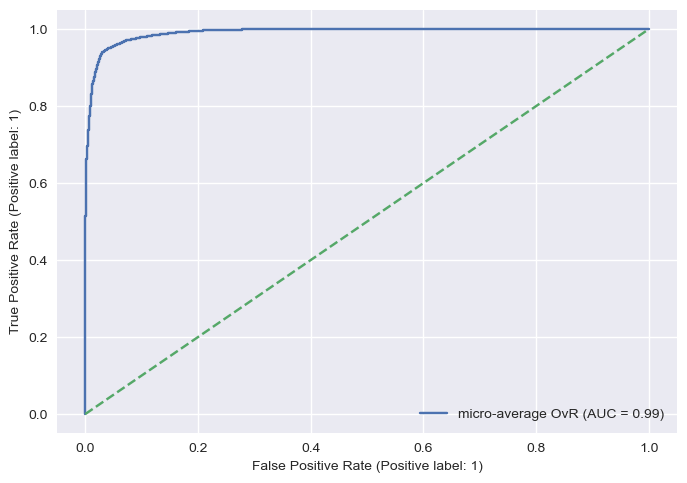

In [161]:
roc_display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_lr_pred_proba.ravel(),
    name="micro-average OvR"
)


plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

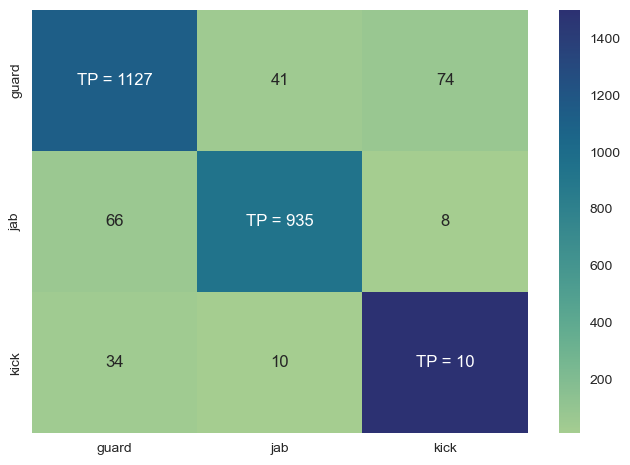

In [162]:
# plot confusion matrix heatmap
cm = confusion_matrix(y_test,lr.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TP = ' + str(value[0]), str(value[1]), str(value[2])])
    elif index == 1:
        cm_label.append([str(value[0]), 'TP = ' + str(value[1]), str(value[2])])
    else:
        cm_label.append([str(value[0]), str(value[1]), 'TP = ' + str(value[1])])
        
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=label_binarizer.classes_,
    yticklabels=label_binarizer.classes_
)

In [163]:
coef = lr.best_estimator_['lr'].coef_[0]
feature = lr.best_estimator_['ss'].get_feature_names_out()

<Axes: xlabel='Importance', ylabel='Features'>

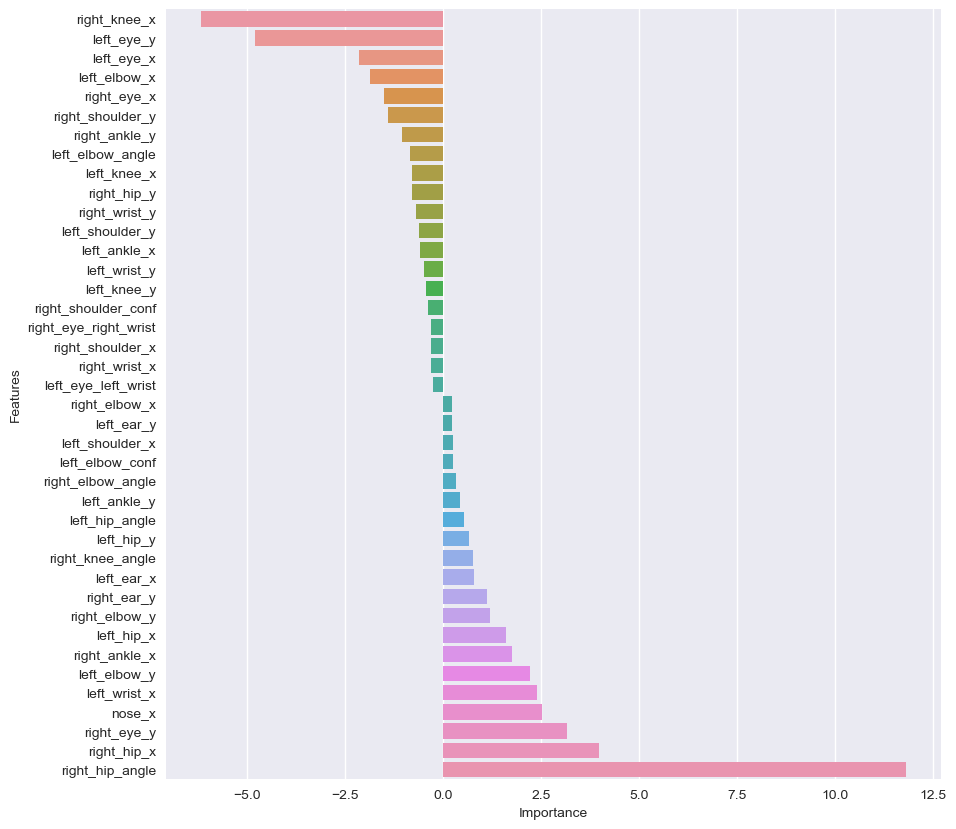

In [164]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(20, 'Importance')
bottom_features = feature_importance.nsmallest(20, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

It is tentatively doing well. As such, I will export this new dataframe to test it more rigorously and see how it does in implementation.

## 9. CSV Export

<a id='export'></a>

In [104]:
path = '../data/04-edited_csv/'
df2.to_csv(os.path.join(path,r'combined_coords2.csv'), index = False)

[Back to top](#part_iii)

## End of Part III <br>
[Part I](Part_1-Imports.ipynb#part_i) <br>
[Part II](Part_2-Cleaning_and_EDA.ipynb#part_ii) <br>
[Part IV](Part_4-Modelling.ipynb#part_iv) <br>
[Part V](Part_5-Implementation.ipynb#part_v)